# Import Libraries

In [1]:
%matplotlib inline
import pandas as pd
import zipfile
import shutil
import urllib
import wqio
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as tick
import scipy.stats as sp
import statsmodels.api as sm

from datetime import datetime
from bs4 import BeautifulSoup
from pylab import rcParams
import platform
rcParams['figure.figsize'] = 15, 10
import re
import os
import sys
import glob
import folium

import matplotlib
import pyproj
from pyproj import Proj

import gzip

import cx_Oracle

import ftplib
import calendar
import datetime
from datetime import date

import qgrid

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\seaborn\apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [2]:
qgrid.set_defaults(show_toolbar=True, grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
qgrid.enable()
qgrid.disable()

In [3]:
import wellapplication as wa

In [4]:
import arcpy
from arcgis.gis import GIS
import json
import arcgis

In [5]:
print("Operating System {:} {:}".format(platform.system(),platform.release()))
print("Python Version {:}".format(sys.version))
print("Pandas Version {:}".format(pd.__version__))
print("Numpy Version {:}".format(np.__version__))
print("Matplotlib Version {:}".format(matplotlib.__version__))
print("Wellapplication Version {:}".format(wa.__version__))

Operating System Windows 10
Python Version 3.6.2 |Continuum Analytics, Inc.| (default, Jul 20 2017, 12:30:02) [MSC v.1900 64 bit (AMD64)]
Pandas Version 0.22.0
Numpy Version 1.13.3
Matplotlib Version 2.0.2
Wellapplication Version 0.5.4


In [6]:
connection_filepath = "G:/My Drive/Python/"
sys.path.append(connection_filepath)
import databaseconnection

In [7]:
connection = databaseconnection.oraconnect()

In [8]:
gis = databaseconnection.get_gis()

# Directories

In [9]:
drive = 'G:/My Drive/WORK/'

fileplace = drive + 'Round_Valley/Data/Chemistry/'
figplace = drive + 'Round_Valley/Writing/Figures/'
shpplace = drive + 'Round_Valley/Data/GIS/'

# Import Functions

## GIS Functions

In [10]:
def df2PntShp(df, x, y, plc, espg):
    import shapefile
    import urllib
    # https://glenbambrick.com/2016/01/24/reproject-shapefile/

    w = shapefile.Writer(shapefile.POINT)

    typeDict = {
        'int64': 'N',
        'float64': 'N',
        'object': 'C',
        'datetime64[ns]': 'D'
    }
    for col in df.columns:
        w.field(str(col), fieldType=typeDict[df[col].dtype.name])
    for i in list(df.index):
        w.point(df.ix[i, x], df.ix[i, y])
        w.record(*list(df.ix[i, :].values))

    w.save(str(plc))

    prj = open(plc + ".prj", "w")
    wkt = urllib.urlopen(
        "http://spatialreference.org/ref/epsg/{0}/prettywkt/".format(epsg))
    remove_spaces = wkt.read().replace(" ", "")
    proESPG = remove_spaces.replace("\n", "")
    prj.write(proESPG)
    prj.close()
    print("file saved at {}".format(plc))


def df2PntShpAP(df, x, y, plc, epsg):
    import shapefile

    w = shapefile.Writer(shapefile.POINT)

    typeDict = {
        'int64': 'N',
        'float64': 'N',
        'object': 'C',
        'datetime64[ns]': 'D'
    }
    for col in df.columns:
        w.field(str(col), fieldType=typeDict[df[col].dtype.name])

    for i in df.index:
        w.point(df.loc[i, x], df.loc[i, y])
        w.record(*list(df.loc[i, :].values))

    w.save(str(plc))
    sr = arcpy.SpatialReference(epsg)  #NAD83 zone 12
    arcpy.DefineProjection_management(plc + '.shp', sr)


def df2PntFt(df, x, y, shpplace, shpname, gdb, epsg):
    '''
    input is Pandas Dataframe
    df = dataframe to input
    x = column name of x coordinates
    y = column name of y coordinates
    shpplace = directory to store gis files (directory where the gdb is); do not include gdb name in this string
    gdb = name of geodatabase to store file
    epsg = integer epsg itentifier of projection
    '''
    import arcpy
    arcpy.env.overwriteOutput = True
    df2PntShpAP(df, x, y, shpplace + shpname, epsg)
    arcpy.FeatureClassToFeatureClass_conversion(shpplace + shpname + '.shp',
                                                shpplace + gdb, shpname)
    print("file saved at {}".format(shpplace + gdb + "/" + shpname))


def xl2PntFt(xlfile, x, y, shpplace, shpname, gdb, epsg, sheetname='Sheet1'):
    '''
    Converts excel file into shapefile and feature class.  
    Input should be excel file that has 1 row of column headers on the first row of the spreadsheet.
    Output is a point feature class, a shapefile, and Pandas dataframe of the data
    
    xlfile = string of file and diretory (include extension)
    x = column name of x coordinates
    y = column name of y coordinates
    shpplace = directory to store gis files (directory where the gdb is); do not include gdb name in this string
    gdb = name of geodatabase to store file
    epsg = integer epsg itentifier of projection
    sheetname = optional; name of sheet in excel file where data are stored
    '''
    df = pd.read_excel(xlfile, sheetname)
    df2PntFt(df, x, y, shpplace, shpname, gdb, epsg)
    return df


def reind_inc(df):
    df['increment'] = range(0, len(df))
    df = df.reset_index()
    df = df.set_index('increment')
    return df


def df_to_published_data(df, title):

    df.rename(columns={'Lat_Y': 'y', 'Lon_X': 'x'}, inplace=True)
    fc = gis.content.import_data(df)
    map1 = gis.map(location=[df.x.mean(), df.y.mean()], zoomlevel=12)
    map1.add_layer(
        fc)  #,{"renderer":"ClassedSizeRenderer","field_name": "TDS"})
    xmin = round(df.x.min() - 0.1, 2)
    ymin = round(df.y.min() - 0.1, 2)
    xmax = round(df.x.max() + 0.1, 2)
    ymax = round(df.y.max() + 0.1, 2)

    item_properties = {
        "title": title,
        "tags": "utah, groundwater,water quality",
        "snippet": "Round Valley Water Quality",
        "description": "samples collected by UGS",
        "text": json.dumps({
            "featureCollection": {
                "layers": [dict(fc.layer)]
            }
        }),
        "type": "Feature Collection",
        "typeKeywords": "Data, Feature Collection, Singlelayer",
        "extent": "{:},{:},{:},{:}".format(xmin, ymin, xmax, ymax)
    }

    item = gis.content.add(item_properties)
    return item, map1

## WQP Functions

In [11]:
def changeUnits(df):
    if str(df['Unit']).lower().strip() == 'ug/l':
        df['Unit'] = 'mg/l'
        df['ResultValue'] = df['ResultValue']/1000.0
        if str(df['MDLUnit']).lower().strip() == 'ug/l':
            df['MDLUnit'] = 'mg/l'
            df['MDL'] = df['MDL']/1000.0            
    else:
        pass
    return df

In [12]:
def mergegw(df):
    if df['SampMedia'] == 'Ground Water':
        df['SampMedia'] = 'Groundwater'
    else:
        pass
    return df
    
def cleanparam(x):
    return str(x).strip().title()

In [13]:
def make_less(df):
    if df['DetectCond'] in ['Not Detected','Detected Not Quantified','Below Detection Limit',
                            '*Non-detect    ','Present Below Quantification Limit']:
        df['DetectCond'] = '<'
    elif df['DetectCond'] in ['Present Above Quantification Limit']:
        df['DetectCond'] = '>'
    return df

In [14]:
def make_less_SDWIS(df):
    if df['DetectCond'] in ['Not Detected','Detected Not Quantified']:
        df['DetectCond'] = '<'
        df['ResultValue'] = df['MDL']
        df['Unit'] = df['MDLUnit']
    else:
        df['ResultValue'] = pd.to_numeric(df['ResultValue'],errors='coerce')
    return df

In [15]:
def unitfix(df):
    specieslist = ['CaCO3','Cr','Na']
    for spec in specieslist:
        if spec in str(df['Unit']):
            df['MethSpecies'] = spec
            df['Unit'] = str(df['Unit']).split(" ")[0] 
        elif 'P' in str(df['Unit']):
            df['MethSpecies'] = 'P'
            df['Unit'] = str(df['Unit']).split(" ")[0]
        elif 'PO4' in str(df['Unit']):
            df['MethSpecies'] = 'P'
            df['ResultValue'] = df['ResultValue']*0.3261
            df['Unit'] = str(df['Unit']).split(" ")[0]
        elif 'N' in str(df['Unit']):
            df['MethSpecies'] = 'N'
            df['Unit'] = str(df['Unit']).split(" ")[0]
        elif 'NO3' in str(df['Unit']):
            df['MethSpecies'] = 'N'
            df['ResultValue'] = df['ResultValue']*0.2259
            df['Unit'] = str(df['Unit']).split(" ")[0]
        else:
            pass
    return df

## SDWIS Functions

In [16]:
def reind_inc(df):
    """Dataframe Incrementer"""
    df['increment'] = range(0,len(df))
    df = df.reset_index()
    df = df.set_index(['increment'])
    return df

def piv_chem(stations, chemistry):
    """Pivot Chemistry for SDWIS"""
    paramdict = {'nitrate-nitrite':'NO3+NO2-N', 'nitrate':'NO3', 'sulfate':'SO4',
             'nitrite':'NO2', 'turbidity':'turb', 'silver':'Ag',
             'barium':'Ba', 'fluoride':'F', 
             'potassium':'K', 'arsenic':'As', 'mercury':'Hg',
             'sodium':'Na', 'selenium':'Se', 'cadmium':'Cd',
             'copper, free':'Cu', 'zinc':'Zn', 'silica':'Si',
             'magnesium':'Mg', 'lead':'Pb', 'calcium':'Ca',
             'nitrogen-ammonia as (n)':'NH4-N', 'chloride':'Cl', 
             'iron':'Fe', 'manganese':'Mn', 'phosphate, total':'PO4', 
             'carbon dioxide':'CO2', 'bicarbonate as hco3':'HCO3', 
             'alkalinity, total':'Alk', 'tds':'TDS', 'hardness, carbonate':'Hard', 
             'conductivity @ 25 c umhos/cm':'Cond', 
             'hardness, total (as caco3)':'Hard','iron, dissolved':'Fe', 'ph':'pH',
             'alkalinity, carbonate':'Alk'}
    
    
    chemistry['Param'] = chemistry['Param'].apply(lambda x: str(x).strip().lower(),1)
    chemistry['ParAbb'] = chemistry['Param'].apply(lambda x: paramdict.get(x),1)
    chemistry.drop_duplicates(subset=['SampleId','ParAbb'],inplace=True)
    chem_piv = chemistry.pivot(index='SampleId',columns='ParAbb',values='ResultValue')
    chem_piv.reset_index(inplace=True)

    chem_dict = chemistry[['SampleId','StationId']].set_index('SampleId').to_dict()['StationId']
    chem_piv['StationId'] =chem_piv['SampleId'].apply(lambda x: chem_dict.get(x),1)
    chem_piv = pd.merge(chem_piv,stations,on='StationId')
    
    sampdatedict = chemistry[['SampleId','SampleDate']].set_index('SampleId').to_dict()['SampleDate']
    chem_piv['SampleDate'] = chem_piv['SampleId'].apply(lambda x: sampdatedict.get(x), 1)

    chem_piv_piper = chem_piv.dropna(subset=['Ca','Na','SO4','Cl','Mg','HCO3'])
    chem_piv_piper = chem_piv_piper[(chem_piv_piper['Na'] > 0)&(chem_piv_piper['SO4'] > 0)&(chem_piv_piper['Cl'] > 0)]
    chem_piv_piper = reind_inc(chem_piv_piper)
    return chem_piv, chem_piv_piper

def filldate(df):
    """Correct Date Errors for SDWIS; Use analysis date if sample date is not available"""
    if pd.isnull(df['SampleDate']):
        df['SampleDate'] = pd.to_datetime(df['AnalysisDate'],format='%Y-%m-%d %H:%M',errors='coerce')
    else:
        df['SampleDate'] = pd.to_datetime(df['SampleDate'],format='%Y-%m-%d %H:%M',errors='coerce')
    return df

def changeUnits(df):
    """Convert all units from ug/L to mg/L"""
    df['Unit'] = str(df['Unit']).lower().strip()
    df['MDLUnit'] = str(df['MDLUnit']).lower().strip()
    
    if df['Unit'] == 'ug/l' or df['Unit'] == 'UG/L     ':
        df['Unit'] = 'mg/l'
        df['ResultValue'] = df['ResultValue']/1000.0
        if str(df['MDLUnit']).lower().strip() == 'ug/l' or df['MDLUnit'] == 'UG/L     ':
            df['MDLUnit'] = 'mg/l'
            df['MDL'] = df['MDL']/1000.0            
    else:
        pass
    return df

def fillmdlspot(df):
    """
    Fixes MDL in SDWIS
    PARAM
    ------
    x[0] = result_va
    x[1] = Unit
    x[2] = MDL
    x[3] = MDLUnit
    
    RETURNS
    -------
    remark_cd, result_va, Unit
    """
    if pd.isnull(df['ResultValue']) and pd.notnull(df['MDL']):
        df['DetectCond'] = '<'
        df['ResultValue'] = df['MDL'] 
        df['Unit'] = df['MDLUnit']
    elif df['ResultValue'] == 0.0:
        df['DetectCond'] = '<'
        df['ResultValue'] = df['MDL'] 
        df['Unit'] = df['MDLUnit']
    else:
        pass
    return df

def quer_stations(x, connection):
    """
    x = list of bbox coordinates; lat top, long left, lat bottom, long right
    returns stations, chemistry
    """
    
    SQLtext = """
    SELECT 
    UTV80.TINWSF.TINWSF_IS_NUMBER AS "StationId",
    UTV80.TINWSF.NAME AS "StationName",
    UTV80.TINWSF.TYPE_CODE AS "StationType",
    UTV80.TINWSYS.TINWSYS_IS_NUMBER AS "OrgId",
    UTV80.TINWSYS.NAME AS "OrgName",
    UTV80.TINLOC.LATITUDE_MEASURE AS "Lat_Y",
    UTV80.TINLOC.LONGITUDE_MEASURE AS "Lon_X",
    UTV80.TINLOC.SRC_MAP_SCALE_NUM AS "MapScale",
    UTV80.TINLOC.HORIZ_ACCURACY_MSR AS "HorAcc",
    UTV80.TINLOC.HZ_COLLECT_METH_CD AS "HorCollMeth",
    UTV80.TINLOC.HORIZ_REF_DATUM_CD AS "HorRef",
    UTV80.TINLOC.VERTICAL_MEASURE AS "Elev",
    UTV80.TINLOC.VERT_ACCURACY_MSR AS "ElevAcc",
    UTV80.TINLOC.VER_COL_METH_CD AS "ElevMeth",
    UTV80.TINLOC.VERT_REF_DATUM_CD AS "ElevRef"

    FROM
    UTV80.TINWSF
    JOIN UTV80.TINWSYS ON  UTV80.TINWSF.TINWSYS_IS_NUMBER = UTV80.TINWSYS.TINWSYS_IS_NUMBER  
    JOIN UTV80.TINLOC ON  UTV80.TINWSF.TINWSF_IS_NUMBER = UTV80.TINLOC.TINWSF_IS_NUMBER 

    WHERE
    (UTV80.TINWSF.TYPE_CODE IN('WL','SP','IN')) -- Spring, well, or intake
    AND (UTV80.TINLOC.LATITUDE_MEASURE < {:})
    AND (UTV80.TINLOC.LONGITUDE_MEASURE > {:})
    AND(UTV80.TINLOC.LATITUDE_MEASURE > {:})
    AND (UTV80.TINLOC.LONGITUDE_MEASURE < {:})
    """
    SQL = SQLtext.format(x[0],x[1],x[2],x[3]) # 40.44, -111.51, 40.30, -111.35
    stations = pd.read_sql(SQL, con = connection)
    return stations
    
def quer_chem(x, connection,stlist):
    SQLtext = """
    SELECT
    UTV80.TINWSF.TYPE_CODE AS "SampType", 
    UTV80.TINWSF.TINWSF_IS_NUMBER AS "StationId", 
    UTV80.TINWSYS.TINWSYS_IS_NUMBER AS "OrgId", 
    UTV80.TINWSYS.NAME AS "OrgName", 
    UTV80.TSASAMPL.TSASAMPL_IS_NUMBER AS "SampleId", 
    UTV80.TSASAMPL.COLLLECTION_END_DT AS "SampleDate", 
    UTV80.TSASAMPL.COLLCTN_END_TIME AS "SampleTime", 
    UTV80.TSAANLYT.NAME AS "Param", 
    UTV80.TSASAR.CONCENTRATION_MSR AS "ResultValue", 
    UTV80.TSASAR.UOM_CODE AS "Unit", 
    UTV80.TSASAR.ANALYSIS_START_DT AS "AnalysisDate", 
    UTV80.TSASAR.DETECTN_LIMIT_NUM AS "MDL", 
    UTV80.TSASAR.DETECTN_LIM_UOM_CD AS "MDLUnit", 
    UTV80.TSAANLYT.CAS_REGISTRY_NUM AS "CAS_Reg", 
    UTV80.TSASAR.TSASAR_IS_NUMBER AS "ID_NUM",
    UTV80.TSASAMPL.COMMENT_TEXT AS "SamplePointComment",
    UTV80.TSASMPPT.DESCRIPTION_TEXT AS "SamplePointDesc"

    FROM 
    UTV80.TINWSF -- Water System Facility (water source)
    JOIN UTV80.TINWSYS ON -- Water System (town or water provider)
    UTV80.TINWSF.TINWSYS_IS_NUMBER = UTV80.TINWSYS.TINWSYS_IS_NUMBER 
    JOIN UTV80.TSASMPPT ON  -- Sample point
    UTV80.TINWSF.TINWSF_IS_NUMBER = UTV80.TSASMPPT.TINWSF0IS_NUMBER
    JOIN UTV80.TSASAMPL ON -- Sample
    UTV80.TSASMPPT.TSASMPPT_IS_NUMBER = UTV80.TSASAMPL.TSASMPPT_IS_NUMBER  -- Sample Point
    JOIN UTV80.TSASAR ON -- Sample Result
    UTV80.TSASAMPL.TSASAMPL_IS_NUMBER = UTV80.TSASAR.TSASAMPL_IS_NUMBER   -- Sample Number
    JOIN UTV80.TSAANLYT ON -- Analyte
    UTV80.TSASAR.TSAANLYT_IS_NUMBER = UTV80.TSAANLYT.TSAANLYT_IS_NUMBER  -- Analyte Number

    WHERE (UTV80.TINWSF.TYPE_CODE IN('WL','SP','IN')) -- Spring or well or intake
    AND UTV80.TSASMPPT.SOURCE_TYPE_CODE = 'RW' -- Raw (unfiltered) water
    AND UTV80.TSASMPPT.TYPE_CODE IN('RW','EP','SR') -- From source
    AND UTV80.TINWSF.TINWSF_IS_NUMBER IN('{:}') 
    ORDER BY UTV80.TINWSF.ST_ASGN_IDENT_CD
    """
    
    SQL = SQLtext.format("','".join(stlist))
    chemistry = pd.read_sql(SQL, con = connection, parse_dates=['SampleDate','SampleTime'])
    return chemistry

def winnowchem(chemistry):
    sdwis_drop = ['aroclor 1016', 'aroclor 1248', 'coliform (tcr)','di(2-ethylhexyl) adipate',
              '1,2-dichloropropane', 'dichlorodifluoromethane', 'trichlorotrifluoroethane', '1,1-dichloroethylene',
              'trans-1,3-dichloropropene', 'atrazine', 'trans-1,2-dichloroethylene', 'dichloromethane',
              'hexachlorobenzene', 'benzene', 'carbon, total',
              'aldicarb sulfone', '1,2,4-trichlorobenzene', 'propachlor', 'xylenes, total', 
              'toluene', '2,4,5-tp', 'radium-228','chloroform', 'isopropylbenzene', 'di(2-ethylhexyl) phthalate',
              '3-hydroxycarbofuran', 'lasso',
              'dibromochloromethane', 'bhc-gamma', 'carbofuran', 'styrene',
              'total polychlorinated biphenyls (pcb)', 'hexachlorocyclopentadiene', 'p-dichlorobenzene', 'simazine',
              'methomyl', 'picloram', 'vinyl chloride', 'benzo(a)pyrene',
              'hexachlorobutadiene', 'bromomethane', 'aroclor 1242', 'p-isopropyltoluene', 
              'dieldrin','methoxychlor', '1,1,1-trichloroethane', 
              'oxamyl', 'bromobenzene', 'butachlor', '1,2,4-trimethylbenzene', 'dinoseb', 
              '1,1,2-trichloroethane', 'o-chlorotoluene', 'dalapon',
              'chloromethane', 'gamma-chlordane', 'cis-1,2-dichloroethylene',
              'o-dichlorobenzene', 'aldicarb', '1,3-dichloropropane',
              'chlorobenzene', 'heptachlor', 'trichloroethylene', '1,2,3-trichloropropane', 
              'aldicarb sulfoxide','1,2-dichloroethane', 'carbon tetrachloride',
              'chlordane', 'ethylbenzene', 'sec-butylbenzene',
              'bromodichloromethane', 'e. coli','mbas - foaming agents (surfactants)', 'bromochloromethane',
              '1,1-dichloropropene', 'metolachlor', 'endrin','dichlorobenzenes, total', 
              'p-chlorotoluene', 'tetrachloroethylene',
              'toxaphene', 'naphthalene', 'foaming agents (surfactants)',
              'carbaryl', 'chloroethane', 'pentachlorophenol', 'aroclor 1254',
              'cryptosporidium', 'trichlorofluoromethane',
              '1,3,5-trimethylbenzene', 'dicamba', '2,2-dichloropropane',
              '1,2,3-trichlorobenzene', '2,4-d', 'heptachlor epoxide', 'metribuzin', 'chlorine',
              'n-butylbenzene', '1,3-dichloropropene', '1,1-dichloroethane',
              '1,1,1,2-tetrachloroethane', 'tthm', 'bromoform', 'aldrin',
              '1,1,2,2-tetrachloroethane', 'tert-butylbenzene',
              'n-propylbenzene', 'gross alpha particle activity', 'radium-226','ethylene dibromide',
              'asbestos', 'endothall', 'aroclor 1260', 'n-nitrosodi-n-propylamine',
              'trichloroacetic acid', '38-strontium-90', '2,3,7,8-tcdd',
              'methyl tert-butyl ether', 'diquat',
              'bis(2-ethylhexyl) phthalate', 'm-xylene', 'aroclor 1232', 'color', 'alpha-chlordane',
              'cis-1,3-dichloropropene', 'm-dichlorobenzene', 'dibromomethane',
              'total haloacetic acids (haa5)', 'aroclor 1221', '1,2-dibromo-3-chloropropane',
              'uv absorbance @254 nm','perchlorate']

    return chemistry[~chemistry['Param'].isin(sdwis_drop)]
    
    
def sql_bbox(x, connection):
    stations = quer_stations(x, connection)
    print('stations queried')
    stations['StationName'] = stations['StationName'].apply(lambda x: str(x).strip().title(), 1)
    typedict = {'WL':'Well', 'SP':'Spring', 'IN':'Intake'}
    
    stations['StationType'] = stations['StationType'].apply(lambda x: typedict.get(x),1)
    print(stations['StationType'].unique())
    stlist = list(stations['StationId'].unique())
    stlist = [str(i) for i in stlist]
    stations['StationId'] = stations[['OrgId','StationId']].apply(lambda x: 'SDWIS-{:03}-{:06}'.format(x[0],x[1]),1)
    stations['data_source'] = 'SDWIS'
    
    chemistry = quer_chem(x, connection, stlist)
    print('chem queried')
    chemistry = winnowchem(chemistry)

    chemistry = chemistry.apply(filldate,1)
    print('dates fixed')
    chemistry = chemistry.apply(fillmdlspot,1)
    print('no detects fixed')
    chemistry = chemistry.apply(changeUnits,1)
    print('units fixed')
    chemistry['StationId'] = chemistry[['OrgId','StationId']].apply(lambda x: 'SDWIS-{:03}-{:06}'.format(x[0],x[1]),1)
    chemistry['SampleId'] = chemistry[['StationId','SampleId']].apply(lambda x: '{:}-{:}'.format(x[0],x[1]),1)
    chemistry['data_source'] = 'SDWIS'
    return stations, chemistry

## Other functions

In [17]:
import numpy as np
import scipy


def geo_mean_overflow(iterable):
    a = np.log(iterable)
    return np.exp(a.sum()/len(a))

def geo_mean(iterable):
    a = np.array(iterable)
    return a.prod()**(1.0/len(a))

# WQP Data

In [17]:
sType = ['Well','Spring','Subsurface','Stream']
cType = ['Inorganics, Major, Non-metals', 'Inorganics, Major, Metals','Information',
         'Inorganics, Minor, Metals', 'Inorganics, Minor, Non-metals','Stable Isotopes',
         'Nutrient','Physical']

bBox = '-111.54,40.28,-111.29,40.48'

In [ ]:
wq = wa.WQP(bBox,'bBox',siteType = sType, characteristicType = cType)
wq.results.to_pickle(fileplace + 'raw_results.pickle')
wq.stations.to_pickle(fileplace + 'raw_stations.pickle')

In [ ]:
rv_gw_results = wq.massage_results()
rv_gw_stations = wq.massage_stations()
rv_gw_results.to_pickle(fileplace + 'massage_raw_results.pickle')
rv_gw_stations.to_pickle(fileplace + 'massage_raw_stations.pickle')

## Read Stored WQP Data

In [18]:
rv_gw_results = pd.read_pickle(fileplace + 'massage_raw_results.pickle')
rv_gw_stations = pd.read_pickle(fileplace + 'massage_raw_stations.pickle')

In [19]:
rv_gw_results['SampMedia'].unique()

array([nan, 'Surface Water', 'Groundwater', 'Other'], dtype=object)

In [20]:
rv_gw_results['DetectCond'].unique()

array([nan, 'Not Detected', 'Below Detection Limit',
       'Present Above Quantification Limit'], dtype=object)

In [21]:
# Changes word "Ground Water" to "Groundwater" for the sample media      
rv_gw_results = rv_gw_results.apply(mergegw,axis=1)
rv_gw_results['Param'] = rv_gw_results['Param'].apply(lambda x: cleanparam(x),1)

In [22]:
# Adds < and > symbols to detection column 
rv_gw_results = rv_gw_results.apply(make_less, axis=1)   

In [23]:
rv_gw_results['data_source'] = 'WQP'

In [24]:
rv_gw_stations['StationId'] = rv_gw_stations['StationId'].apply(lambda x: x.replace('_WQX',''),1)
rv_gw_results['StationId'] = rv_gw_results['StationId'].apply(lambda x: x.replace('_WQX',''),1)


In [25]:
rv_gw_results['MethSpecies'] = np.nan
rv_gw_results = rv_gw_results.apply(unitfix,1)
rv_gw_results['Unit'].unique()

array(['mg/l', 'deg C', 'umho/cm', 'None', 'ft3/sec', 'NTU', 'ft', 'ft3/s',
       'uS/cm @25C', 'm3/sec', 'm', 'std units', '%', 'tons/ac ft', 'nan',
       'ppt', 'g/min', 'mm3/l', 'ug/g', 'ppth', 'mm', 'ug/l', 'tons/day',
       'uS/cm', 'ft/sec', 'mgd'], dtype=object)

In [26]:
pdrop = ['Length, Total (Fish)','Sodium Adsorption Ratio [(Na)/(Sq Root Of 1/2 Ca + Mg)]',
'Thiabendazole-D4', 'Albuterol-D9', 'Diltiazem-D3','Sum Of Anions', 'Sum Of Cations','Caffeine-D9',
       'Trimethoprim-D9', 'Acetaminophen-D3', 'Norfluoxetine-D6','Kjeldahl Nitrogen',
       'Methadone-D9', 'Oxycodone-D3', 'Hydrocodone-D3', 'Temazepam-D5',
       'Caffeine-Trimethyl-13C3', 'Sulfamethoxazole-13C6', 'Cotinine-D3',
       'Amphetamine-D6', 'Codeine-D6', 'Pseudoephedrine-D3','Ethyl Nicotinate-D4', 'Carbamazepine-D10',
       'Diphenhydramine-D3', 'Fluoxetine-D6', 'Diazepam-D5', 'Diesel Fuel',
         'Biochemical Oxygen Demand, Standard Conditions','Cell Volume', 'Species Rank',
       'Decafluorobiphenyl', 'Fluoranthene-1,2,3,4,5,6,7,8,9,10-D10']
rv_gw_results = rv_gw_results[~rv_gw_results['Param'].isin(pdrop)]

In [27]:
rv_gw_stations['data_source'] = 'WQP'

In [28]:
rv_gw_results.to_pickle(fileplace + 'wqp_results.pickle')
#piv_gw2.to_pickle(fileplace+'wqp_gw_res_piv.pickle')
rv_gw_stations.to_pickle(fileplace + 'wqp_stations.pickle')

In [29]:
main_crk_stations = ['UTAHDWQ_WQX-5910617','UTAHDWQ_WQX-5910619','UTAHDWQ_WQX-5913460',
                     'UTAHDWQ_WQX-5910622','UTAHDWQ_WQX-5910620','UTAHDWQ_WQX-4996901',
                     'UTAHDWQ_WQX-4996904','UTAHDWQ_WQX-4996905','UTAHDWQ_WQX-4996906',
                     'UTAHDWQ_WQX-4996908','UTAHDWQ_WQX-4996908','UTAHDWQ_WQX-4996920',
                     'UTAHDWQ_WQX-5910636','UTAHDWQ_WQX-5910639',
                     'UTAHDWQ_WQX-4996915','UTAHDWQ_WQX-4996917','UTAHDWQ_WQX-4996910']
little_hob_stations = ['UTAHDWQ_WQX-4996915','UTAHDWQ_WQX-4996917','UTAHDWQ_WQX-4996910']

# AWQMS Data

In [31]:
awqmsFile = fileplace + 'awqms Standard Export 16007.xlsx'
awqms = pd.read_excel(awqmsFile,skiprows=1)

dropcols = []
for column in list(awqms.describe().columns):
    if awqms.describe().loc['count',column] == 0:
        dropcols.append(column)
        
awqms.drop(dropcols, axis=1, inplace=True)

In [32]:
ResFieldDict = {"Activity Conducting Organization1":"OrgName",
                "Monitoring Location ID":"StationId",
                "Method Speciation":"MethSpecies",
                "Monitoring Location Name":"StationName", 
                "Monitoring Location Type":"StationType",
                "Monitoring Location State":"StateCode", 
                "Monitoring Location Latitude":"Lat_Y",
                "Monitoring Location Longitude":"Lon_X", 
                "AnalysisStartDate": "AnalysisDate", 
                "Analytical Method ID": "AnalytMeth",
                "Analytical Method Name": "AnalytMethId",
                "Detection Condition": "DetectCond",
                "Laboratory Comment": "LabComments", 
                "Laboratory Name": "LabName",
                "Detection/Quantitation Limit Type1": "LimitType",
                "Detection/Quantitation Limit Value1": "MDL",
                "Detection/Quantitation Limit Unit1": "MDLUnit",
                "MethodDescriptionText": "MethodDescript",
                "Organization ID": "OrgId", 
                "Characteristic Name": "Param",
                "Project Identifier": "ProjectId", 
                "MeasureQualifierCode": "QualCode",
                "Result CommentText": "ResultComment",
                "Result Status ID": "ResultStatus", 
                "Result Value": "ResultValue",
                "Activity Comment Text": "SampComment", 
                "Activity Depth/Height": "SampDepth",
                "Activity Depth/Altitude Reference Point": "SampDepthRef",
                "Activity Depth/Height Unit": "SampDepthU",
                "Sample Collection EquipmentName": "SampEquip",
                "Sample Fraction": "SampFrac", 
                "Activity Start Date": "SampleDate",
                "Activity ID": "SampleId",
                "Activity Start Time": "SampleTime", 
                "Activity Media Subdivision": "SampMedia",
                "Sample Collection Method ID": "SampMeth",
                "Sample Collection Method Name": "SampMethName",
                "Activity Type": "SampType", 
                "Monitoring Location Identifier": "StationId",
                "Result Unit": "Unit", 
                "USGSPCode": "USGSPCode"}

# Rename Data
awqms = awqms.rename(columns=ResFieldDict)

In [33]:

awqms['MethSpecies'] = awqms['MethSpecies'].apply(lambda x: str(x).replace('as ','').strip() if pd.notnull(x) else x,1)
awqms['MethSpecies'].unique()

array([nan, 'CaCO3', 'N', 'P'], dtype=object)

In [34]:
def changeN(df):
    if 'Inorganic nitrogen' in df['Param'] and df['MethSpecies'] == 'NO3':
        df['ResultValue'] = df['ResultValue']*0.2259
        df['MethSpecies'] = 'N'
    elif 'Nitrate' in df['Param'] and df['MethSpecies'] == 'NO3':
        df['ResultValue'] = df['ResultValue']*0.2259
        df['MethSpecies'] = 'N'
    else:
        pass
    return df
awqms = awqms.apply(changeN,1)


In [35]:
awqms['SampleDate'] = awqms[["SampleDate","SampleTime"]].apply(lambda x: pd.to_datetime(str(x[0])[:11]+str(x[1])[-8:],
                                                                                                                  format='%Y-%m-%d %H:%M:%S',
                                                                                                                  errors='coerce'),1)

In [36]:
droplist = [
    'Depth, data-logger (ported)', 'Velocity - stream',
    'Biochemical oxygen demand, standard conditions', 'Total Coliform',
    'Escherichia', 'p-Chlorophenyl phenyl ether', '4,6-Dinitro-o-cresol',
    'Acenaphthylene', 'Butyl benzyl phthalate', '1,1,2-Trichloroethane',
    'Bis(2-chloro-1-methylethyl) ether', "3,3'-Dichlorobenzidine",
    'Dibutyl phthalate', 'Benzo[ghi]perylene', 'Nitrobenzene',
    'Di(2-ethylhexyl) phthalate', 'm-Dichlorobenzene', 'Benz[a]anthracene',
    'Ethylene dibromide', 'p-Dichlorobenzene', 'tert-Butylbenzene', 'Benzene',
    'N-Nitrosodimethylamine', 'Cymene', 'Methylene chloride',
    'meta & para Xylene mix', 'sec-Butylbenzene', 'Carbon tetrachloride',
    'Acenaphthene', '1,1-Dichloropropene', '2,4-Dinitrophenol',
    'Chlorodibromomethane', 'C1-C4 Fluoranthenes', 'o-Chlorotoluene',
    'm-Nitroaniline', 'Isophorone', 'Cumene', 'n-Butylbenzene', 'Dibenzofuran',
    '1,1,1,2-Tetrachloroethane', 'trans-1,2-Dichloroethylene',
    'Dichlorobromomethane', '2,4,6-Trichlorophenol', 'Vinyl chloride',
    '1,2-Dichloroethane', 'Bis(2-chloroethoxy)methane', '1,1-Dichloroethylene',
    'o-Cresol', 'trans-1,3-Dichloropropene', '1,2,4-Trichlorobenzene',
    '2,2-Dichloropropane', 'p-Bromophenyl phenyl ether',
    'cis-1,3-Dichloropropene', 'p-Chlorotoluene', 'Dibenz[a,h]anthracene',
    'Benzo[k]fluoranthene', 'C1-C4 Phenanthrenes', '1,2,3-Trichlorobenzene',
    'Dibromomethane', 'Bis(2-chloroethyl) ether', 'o-Xylene',
    'N-Nitrosodiphenylamine', 'p-Chloroaniline', 'Chloroethane',
    '2,4-Dinitrotoluene', 'cis-1,2-Dichloroethylene', 'Hexachlorobenzene',
    'o-Nitroaniline', '1,2,3-Trichloropropane', 'Trichloroethylene',
    '2,4-Dichlorophenol', '2,6-Dinitrotoluene', 'Benzyl alcohol',
    'Chlorobenzene', 'Ethylbenzene', 'C1-C3 Fluorenes', 'Diethyl phthalate',
    'Pyrene', 'o-Dichlorobenzene', 'Benzoic acid', 'Indeno[1,2,3-cd]pyrene',
    '2,4-Dimethylphenol', '1,3-Dichloropropane', 'p-Chloro-m-cresol',
    'Tetrachloroethylene', 'Naphthalene', 'Toluene', 'Di-n-octyl phthalate',
    'Methyl tert-butyl ether', 'n-Propylbenzene', 'Anthracene', 'Benzidine',
    '2-Methylnaphthalene', 'Pentachlorophenol', 'Chloromethane',
    'Benzo(b)fluoranthene', 'Hexachloroethane', '1,3,5-Trimethylbenzene',
    'Tribromomethane', 'Hexachlorocyclopentadiene', 'Azobenzene',
    'Hexachlorobutadiene', 'Benzo[a]pyrene', 'Halon 1011', 'Bromobenzene',
    '2,4,5-Trichlorophenol', 'Aniline', 'Styrene', '1,1,2,2-Tetrachloroethane',
    '2-Chloronaphthalene', 'o-Chlorophenol', 'p-Nitroaniline',
    'N-Nitrosodi-n-propylamine', 'p-Nitrophenol', 'Phenol', 'Chloroform',
    'Carbazole', '1,2,4-Trimethylbenzene', 'Dimethyl phthalate',
    '1,2-Dichloropropane', '1,1-Dichloroethane', 'o-Nitrophenol',
    'C1-C4 Chrysenes', 'Cresol', 'Methyl bromide',
    '1,2-Dibromo-3-chloropropane', '1,1,1-Trichloroethane',
    'Chemical oxygen demand', 'Perchlorate', 'Fecal Coliform',
    'Gasoline range organics', 'Hydrocarbons, petroleum',
    'Diesel range organics', 'Chlorophyll a, uncorrected for pheophytin',
    'Depth, Secchi disk depth', 'Total volatile solids', 'Oil and Grease',
    'Ethylene glycol', 'Propylene glycol allyl ether', 'Biomass, periphyton',
    'Chlorophyll a',
    'Carbonaceous biochemical oxygen demand, standard conditions',
    'Dibromodichloromethane', 'o-Xylene, mixt. with m-xylene and p-xylene',
    'p-Cymene', 'Bis(2-chloroisopropyl) ether', 'Chrysene', 'Fluoranthene',
    'Phenanthrene', 'Pheophytin a', 'Chlorophyll a, corrected for pheophytin'
]

awqms = awqms[~awqms['Param'].isin(droplist)]

In [37]:
awqms = awqms.apply(changeUnits,1)
awqms['data_source'] = 'awqms'


In [38]:
astatcols = ["OrgName", "StationId", "StationName", "StationType", "StateCode", "Lat_Y", "Lon_X"]
awqms_stations = awqms[astatcols]
awqms_stations.drop_duplicates(inplace=True)
awqms_stations['data_source'] = 'awqms'

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [39]:


awqms = awqms.apply(make_less, axis=1)   

In [40]:
dropcols = [
    'Activity Start Time Zone', 'Activity Relative Depth',
    'Lab Sample Preparation Method Context1', 'SampleTime',
    'Lab Sample Preparation Method Name1', 'Substance Dilution Factor1',
    'Lab Sample Preparation Start Date1', 'Lab Batch ID', 'StateCode',
    'Lab Sample ID', 'Chain of Custody ID', 'Activity Top Depth/Height',
    'Detection Limit Type2', 'Detection Limit Value2', 'Detection Limit Unit2',
    'Laboratory Accreditation Indicator', 'Lab Sample Preparation Method ID1',
    'SampDepthU', 'Activity Top Depth/Height Unit',
    'Analytical Method Qualifier', 'Activity Top Depth/Height Unit',
    'Analytical Method Description', 'Activity Bottom Depth/Height',
    'Activity Bottom Depth/Height Unit', 'Project ID1', 'SampDepthRef',
    'Project ID2', 'Analytical Method Context', 'Analysis Start Date',
    'Result Depth/Height Unit', 'Result Analytical Method ID',
    'Result Analytical Method Context', 'Result Analytical Method Name',
    'Result Analytical Method Qualifier','Activity Media',
    'Result Analytical Method Description',
    'Detection/Quantitation Limit Type2',
    'Detection/Quantitation Limit Value2',
    'Detection/Quantitation Limit Unit2', 'Result Depth/Height',
    'Result Comment', 'Method Speciation', 'Sample Collection Method Context',
    'Assemblage Sampled', 'Value Type', 'Time Basis', 'Temperature Basis',
    'Equipment ID', 'Result UID', 'Data Logger Line', 'Result Qualifier',
    'Activity Comment'
]
for col in dropcols:
    if col in awqms.columns:
        awqms.drop(col, axis=1, inplace=True)
awqms.columns

Index(['OrgId', 'SampleId', 'SampType', 'SampleDate', 'SampDepth', 'OrgName',
       'StationId', 'StationName', 'StationType', 'Lat_Y', 'Lon_X', 'SampMeth',
       'SampMethName', 'Sample Collection Equipment Name', 'DetectCond',
       'Param', 'MethSpecies', 'SampFrac', 'ResultValue', 'Unit',
       'ResultStatus', 'LabName', 'LimitType', 'MDL', 'MDLUnit',
       'data_source'],
      dtype='object')

In [41]:
awqms['StationId'] = awqms['StationId'].apply(lambda x: 'UTAHDWQ-'+str(x),1)
awqms_stations['StationId'] = awqms_stations['StationId'].apply(lambda x: 'UTAHDWQ-'+str(x),1)

In [42]:
awqms.to_pickle(fileplace + 'awqms_results.pickle')
awqms_stations.to_pickle(fileplace + 'awqms_stations.pickle')
#piv_awqms_merge.to_pickle(fileplace+'awqms_piv.pickle')

# SDWIS Data

In [43]:
sdwis_bBox = [40.44, -111.6, 40.30, -111.35]
sdwis_stations, sdwis_chemistry = sql_bbox(sdwis_bBox, connection)

#wa.piper(chem_piv_piper,type_col='',var_col='TDS')

stations queried
['Spring' 'Well' 'Intake']
chem queried
dates fixed
no detects fixed
units fixed


In [44]:
sdwis_chemistry['Unit'].unique()

array(['mg/l', 'ntu', 'ph', 'pci/l', '', 'umho/cm', 'mfl', 'units'], dtype=object)

In [45]:
sdwis_stations['StationType'].unique()

array(['Spring', 'Well', 'Intake'], dtype=object)

In [46]:
sdwis_chemistry['data_source'] = 'SDWIS'

In [47]:
sdwis_chemistry['Param'] = sdwis_chemistry['Param'].apply(lambda x: str(x).strip().title(),1)

In [48]:
def addSpecies(df):
    if df['Param'] == 'Nitrate-Nitrite' or df['Param'] == 'Nitrate-Nitrite':
        df['MethSpecies'] = 'N'
    else:
        pass
    return df
sdwis_chemistry['MethSpecies'] = np.nan
sdwis_chemistry = sdwis_chemistry.apply(addSpecies,1)
sdwis_chemistry['Param'].unique()

array(['Chlorobenzene', 'Cis-1,2-Dichloroethylene', '1,2-Dichloropropane',
       'Styrene', 'Benzene', 'Trichloroethylene', 'Chromium', 'Turbidity',
       'Tds', 'Sulfate', 'Lead', 'Silver', 'Barium', 'Arsenic', 'Cadmium',
       'Mercury', 'Nitrate', 'Nitrite', 'Sodium', 'Fluoride', 'Selenium',
       'Nitrate-Nitrite', 'Manganese', 'Chloride', 'Silica', 'Iron',
       'Total Polychlorinated Biphenyls (Pcb)', 'Simazine',
       'Pentachlorophenol', 'Xylenes, Total', 'Toxaphene', 'Copper, Free',
       'Calcium', 'Magnesium', 'Chromium, Hex', 'Phosphate, Total',
       'Nitrogen-Ammonia As (N)', 'Potassium', 'Zinc',
       'Bicarbonate As Hco3', 'Carbon Dioxide', 'Ph', 'Nickel',
       'Thallium, Total', 'Antimony, Total', 'Beryllium, Total', 'Cyanide',
       'Trans-1,2-Dichloroethylene', '1,1,2-Trichloroethane',
       '1,2,4-Trichlorobenzene', 'Dichloromethane', 'Bromodichloromethane',
       'Bromoform', 'Dibromochloromethane', 'Tthm', 'Chloroform',
       'Gross Beta Particle Ac

In [49]:
dropp =['1,3-Dichloropropene', 'N-Butylbenzene','Hydroxide As Calcium Carbonate',
        'Gross Alpha, Excl. Radon & U', 'Gross Beta Particle Activity',
       'Tert-Butylbenzene', 'Sec-Butylbenzene', 'Isopropylbenzene','Trans-1,2-Dichloroethylene',
       'Bromochloromethane', '1,1,1,2-Tetrachloroethane','1,1,1-Trichloroethane'
       'O-Chlorotoluene', 'P-Chlorotoluene', '1,2,3-Trichlorobenzene',
       '1,2,4-Trimethylbenzene', 'Chloromethane', '1,3-Dichloropropane',
       '1,1-Dichloroethane', 'Dichlorobenzenes, Total','Propachlor', 'Metribuzin', 
        'Carbaryl', 'Butachlor', 'Aldrin',
       'Dicamba', 'Methomyl', '3-Hydroxycarbofuran', 'Dieldrin',
       'Metolachlor', 'Cryptosporidium',
        'Lasso', '2,4-D', 'Atrazine',
        '1,1,2-Trichloroethane', '1,2,4-Trichlorobenzene',
       '1,2-Dichloroethane', 'Hexachlorobenzene', 'Simazine',
       'Pentachlorophenol', 'Hexachlorocyclopentadiene', 'Heptachlor',
       'Dichloromethane', 'Aldicarb Sulfoxide', 'Styrene',
       '1,1-Dichloroethylene', 'Benzene', '1,2-Dichloropropane',
       'Aldicarb',
        'Bromodichloromethane', 'Tthm', 'Dibromochloromethane', 'Bromoform',
        'Vinyl Chloride', '1,1,1-Trichloroethane',
        'Mbas - Foaming Agents (Surfactants)',
       'Color', 'Odor', 'Trans-1,3-Dichloropropene', 'M-Dichlorobenzene',
       'Gamma-Chlordane', 'Alpha-Chlordane', 'Aroclor 1260',
       'Aroclor 1254', 'Aroclor 1248', 'Aroclor 1242', 'Aroclor 1232',
       'Aroclor 1221', 'Aroclor 1016', 'Trichlorotrifluoroethane',
       'N-Nitrosodi-N-Propylamine', 'Methyl Tert-Butyl Ether',
       'Cis-1,3-Dichloropropene', 'Dibromomethane',
       '1,1-Dichloropropene', '1,1,2,2-Tetrachloroethane',
       '1,2,3-Trichloropropane', 'Bromomethane', 'Chloroethane',
       '2,2-Dichloropropane', 'N-Propylbenzene', 'Bromobenzene',
       'Naphthalene', 'P-Isopropyltoluene', '1,3,5-Trimethylbenzene',
       'Hexachlorobutadiene', 'Trichlorofluoromethane',
       'Dichlorodifluoromethane','Cis-1,2-Dichloroethylene', 'Carbon Tetrachloride',
       'Chlorobenzene','Aldicarb Sulfone', 'P-Dichlorobenzene', 'Toxaphene', 'Carbofuran',
       'Benzo(A)Pyrene', 'Ethylbenzene', 'Xylenes, Total', 'Bhc-Gamma',
       'O-Dichlorobenzene', 'Picloram', '2,4,5-Tp',
       'Di(2-Ethylhexyl) Adipate', 'Dalapon', 'Di(2-Ethylhexyl) Phthalate',
       'Dinoseb', 'Toluene', 'Endrin', 'Oxamyl', 'Heptachlor Epoxide',
       'Tetrachloroethylene','Methoxychlor', 'Total Polychlorinated Biphenyls (Pcb)',
       'Trichloroethylene', 'Chlordane',]
sdwis_chemistry = sdwis_chemistry[~sdwis_chemistry['Param'].isin(dropp)]


In [50]:
sdwis_stations.to_pickle(fileplace + 'sdwis_stations.pickle')
sdwis_chemistry.to_pickle(fileplace + 'sdwis_results.pickle')
#sdwis_chem_piv.to_pickle(fileplace+'sdwis_piv.pickle')

# UGS Data

In [51]:
chemdata = pd.read_table(fileplace+'UTGS_EDD_20170907.txt', error_bad_lines=False, memory_map=True)
chemdata['SampleDate'] = chemdata[['Sample Date','Sample Time']].apply(lambda x: pd.to_datetime(str(x[0])[:10]+" "+str(x[1]),
                                                                                                format='%m/%d/%Y %H:%M',
                                                                                                errors='coerce'),1)

# Pick Relevant Sites
chemdata = chemdata[chemdata['Sample Description'].isin(['402313111262601', '40224111251901', '402208111241401', '402023111244501', 
                                            '402136111234201','402131111231601', '402439111284601'])]

chemdata = chemdata.rename(columns={'Sample Description':'StationId','Param Description':'Param','Sample Number':'SampleId',
                                    'Method ID':'Method','Method Description':'MethodDescript'})


def sampFrac(df):
    if 'Filtered' in df['Matrix Description'] and 'Non' not in df['Matrix Description']:
        df['SampFrac'] = 'Dissolved'
    elif 'Non-filtered' in df['Matrix Description']:
        df['SampFrac'] = 'Total'
    else:
        pass
    return df
chemdata = chemdata.apply(sampFrac,1)

chemdata['Unit'] = chemdata['Units'].apply(lambda x: str(x).lower().replace('-','/'),1)
chemdata['MDLUnit'] = chemdata['Unit'] 

def getDetect(df):
    df['MDL'] = df['Method Detect Limit']
    if 'U' in str(df['Result Code']) or '<' in str(df['Problem Identifier']):
        df['DetectCond'] = '<'
        df['ResultValue'] = df['Method Detect Limit']
    else:
        df['ResultValue']= pd.to_numeric(df['Result Value'],errors='coerce')
    return df

chemdata = chemdata.apply(getDetect, axis=1)

chemparameter = {'HCO3':'Bicarbonate',
                'Ca':'Calcium',
                 'ORP_mV':'Oxidation Reduction Potential',
                 'T_C':'Temperature, Water',
                 'Q_cfs':'Stream Flow, Instantaneous',
                'NO3+NO3-N':'Inorganic Nitrogen (Nitrate And Nitrite)',
                 'NO3-N':'Nitrate',
                'Mg':'Magnesium',
                'Na':'Sodium','K':'Potassium',
                'CO3':'Carbonate',
                'SO4':'Sulfate',
                'TDS':'Total Dissolved Solids',
                'Cl':'Chloride',
                'Cond':'Specific Conductance',
                'pH':'pH',
                 'B':'Boron',
                'As':'Arsenic',
                'Fe':'Iron',
                'CaCO3':'Calcium Carbonate',
                'CO2':'Carbon Dioxide',
                'OH':'Hydroxide',
                'Mn':'Manganese','Ag':'Silver','Cd':'Cadnium',
                'PO4-P':'Phosphate','Pb':'Lead','Sb':'Tin',
                 'Se':'Selenium','Tl':'Thallium','Ni':'Nickle'}

chemdata['Param'] = chemdata["Param"].apply(lambda x: chemparameter.get(x,x),1)

chemdrop = ['Project Name',  'Cost Code', 'Agency Bill Code','Method Agency', 'Station ID',
       'Trip ID', 'Collector', 'Sample Received Date','Matrix Description','Problem Identifier','Result Code',
       'Chain of Custody', 'Replicate Number', 'Test Number', 'CAS Number','Sample Detect Limit','Lower Report Limit',
       'Dilution Factor', 'Batch Number', 'Analysis Date', 'Project Comment','Method Detect Limit','Sample Report Limit',
        'Sample Type', 'Units',
       'Sample Comment', 'Test Comment', 'Result Comment','Sample Date','Sample Time','Result Value']


chemdata = chemdata.drop(chemdrop,axis=1)

chemdata

,DetectCond,MDL,MDLUnit,Method,MethodDescript,Param,ResultValue,SampFrac,SampleDate,SampleId,StationId,Unit
53,NaN,0.083000,umhos/cm,120.1,EPA 120.1 Specific Conductivity,Conductivity,433.0000,NaN,2016-08-17 14:00:00,2015643,402313111262601,umhos/cm
54,NaN,8.000000,mg/l,160.1,EPA 160.1 Total Dissolved Solids (TDS),Total Dissolved Solids,258.0000,NaN,2016-08-17 14:00:00,2015643,402313111262601,mg/l
55,NaN,1.691000,mg/l,160.2,EPA 160.2 Total Suspended Solids (TSS),Total Suspended Solids,9.6000,NaN,2016-08-17 14:00:00,2015643,402313111262601,mg/l
56,NaN,0.052000,ntu,180.1,EPA Method 180.1 Turbidity,Turbidity,17.7000,NaN,2016-08-17 14:00:00,2015643,402313111262601,ntu
57,NaN,0.704000,mg/l,325.2,EPA Method 325.2 Chloride,Chloride,15.7000,NaN,2016-08-17 14:00:00,2015643,402313111262601,mg/l
58,NaN,0.092000,mg/l,370.1,EPA Method 370.1 Silica,Silica,17.8000,NaN,2016-08-17 14:00:00,2015643,402313111262601,mg/l
59,<,4.338000,mg/l,375.2,EPA Method 375.2 Sulfate,Sulfate,4.3380,NaN,2016-08-17 14:00:00,2015643,402313111262601,mg/l
60,NaN,0.117000,mg/l,2320B,"SM 2320 B - Alkalinity, bicarbonate, carbonate...",Alkalinity as Calcium Carbonate,183.0000,NaN,2016-08-17 14:00:00,2015643,402313111262601,mg/l
61,NaN,NaN,mg/l,2320B,"SM 2320 B - Alkalinity, bicarbonate, carbonate...",Alkalinity as Carbonate,110.0000,NaN,2016-08-17 14:00:00,2015643,402313111262601,mg/l
62,NaN,NaN,mg/l,2320B,"SM 2320 B - Alkalinity, bicarbonate, carbonate...",Bicarbonate,223.0000,NaN,2016-08-17 14:00:00,2015643,402313111262601,mg/l


In [52]:
site_data_file = fileplace + 'Chem_n_Flow.csv'
ugs_sites = pd.read_csv(site_data_file)
ugs_sites =ugs_sites[pd.notnull(ugs_sites['state_lab_id'])]
ugs_sites['state_lab_id'] = ugs_sites['state_lab_id'].apply(lambda x: str(int(pd.to_numeric(x))),1)
ugs_sites_chem = ugs_sites.set_index(['UofU_lab_id'])
chem_dict = ugs_sites_chem[['T_C','ORP_mV','Q_cfs','pH']].to_dict()
ugs_sites_names = {'UofU_lab_id':'StationId','Name':'StationName','Type':'StationType','Lat':'Lat_Y',
                  'Long':'Lon_X'}
ugs_sites = ugs_sites.rename(columns=ugs_sites_names)


In [53]:
chemstack = ugs_sites.set_index(['datetime','state_lab_id','StationId']).drop(['isotopes','stationid','cond',
                                                                   'genchem','ID','StationType',
                                                                   'Lat_Y','StationName',
                                                                   'Lon_X'],axis=1).stack().reset_index().rename(columns={'level_3':'ParAbb',
                                                                                                                          0:'ResultValue',
                                                                                                                          'datetime':'SampleDate',
                                                                                                                         'state_lab_id':'SampleId'})

chemstack['Unit'] = np.nan

def defineParUnits(df):
    if df['ParAbb'] in ['Mg','Na','K','TDS','CO3','SO4','Cl','NO3+NO3-N', 'HCO3','Ca']:
        df['Unit'] = 'mg/l'
    elif df['ParAbb'] == 'Cond':
        df['Unit'] = 'uS/cm'
    elif df['ParAbb'] == 'Q_cfs':
        df['Unit'] = 'cfs'
    elif df['ParAbb'] == 'T_C':
        df['Unit'] = 'Deg C'
    elif df['ParAbb'] == 'ORP_mV':
        df['Unit'] = 'mV'
        
    else:
        pass
    return df

chemstack = chemstack.apply(defineParUnits,1)
chemstack['SampleDate']=pd.to_datetime(chemstack['SampleDate'],errors='coerce')
chemstack['LabName'] = 'State Lab'
chemstack['data_source'] = 'UGS'
chemstack['Method'] = 'field'
chemstack['Param'] = chemstack['ParAbb'].apply(lambda x: chemparameter[x],1)
chemstack1 = pd.concat([chemstack,chemdata])
chemstack1

,DetectCond,LabName,MDL,MDLUnit,Method,MethodDescript,ParAbb,Param,ResultValue,SampFrac,SampleDate,SampleId,StationId,Unit,data_source
0,NaN,State Lab,NaN,NaN,field,NaN,T_C,"Temperature, Water",17.0000,NaN,2016-08-16 16:15:00,2015647,402136111234201,Deg C,UGS
1,NaN,State Lab,NaN,NaN,field,NaN,ORP_mV,Oxidation Reduction Potential,223.0000,NaN,2016-08-16 16:15:00,2015647,402136111234201,mV,UGS
2,NaN,State Lab,NaN,NaN,field,NaN,pH,pH,8.1800,NaN,2016-08-16 16:15:00,2015647,402136111234201,NaN,UGS
3,NaN,State Lab,NaN,NaN,field,NaN,T_C,"Temperature, Water",12.7000,NaN,2016-08-17 14:00:00,2015643,402313111262601,Deg C,UGS
4,NaN,State Lab,NaN,NaN,field,NaN,ORP_mV,Oxidation Reduction Potential,216.0000,NaN,2016-08-17 14:00:00,2015643,402313111262601,mV,UGS
5,NaN,State Lab,NaN,NaN,field,NaN,pH,pH,7.4700,NaN,2016-08-17 14:00:00,2015643,402313111262601,NaN,UGS
6,NaN,State Lab,NaN,NaN,field,NaN,T_C,"Temperature, Water",14.2000,NaN,2016-08-18 13:30:00,2015644,40224111251901,Deg C,UGS
7,NaN,State Lab,NaN,NaN,field,NaN,ORP_mV,Oxidation Reduction Potential,204.0000,NaN,2016-08-18 13:30:00,2015644,40224111251901,mV,UGS
8,NaN,State Lab,NaN,NaN,field,NaN,pH,pH,7.9100,NaN,2016-08-18 13:30:00,2015644,40224111251901,NaN,UGS
9,NaN,State Lab,NaN,NaN,field,NaN,T_C,"Temperature, Water",14.8000,NaN,2016-08-18 14:30:00,2015645,402208111241401,Deg C,UGS


In [54]:
ugs_sites.drop(['T_C','ORP_mV','Q_cfs','cond','stationid','state_lab_id',
                'datetime','isotopes','genchem','ID','pH'],axis=1,inplace=True)

In [55]:
chemstack1['data_source'] = 'UGS'
ugs_sites['data_source'] = 'UGS'

In [56]:
chemstack1.to_pickle(fileplace+'UGS_chemistry.pickle')
ugs_sites.to_pickle(fileplace+'UGS_stations.pickle')

# Loughlin Data

In [57]:
loughlin = pd.read_excel(fileplace+'LoughlinChemData.xlsx')
#loughlin.drop_duplicates(subset=['SampleId','ParAbb'],inplace=True)


#loughlin['Result'] = loughlin[['Result','MDL']].apply(lambda x: pd.to_numeric(getmdl(x)),1)
loughlin1 = loughlin.drop_duplicates(subset=['SampleId','ParAbb'])
lough_piv = loughlin1.pivot(index='SampleId',columns='ParAbb',values='Result')
lough_piv = lough_piv[['Ag', 'As', 'CO2', 'CO3', 'Ca', 'CaCO3', 'Cd', 
                       'Cl', 'Cond', 'Cr', 'Cu', 'Fe',  'HCO3', 'K', 'Mg',
                       'Mn', 'NO3-N', 'Na', 'Ni', 'OH', 'P', 'PO4-P', 'Pb',
                       'SO4', 'Sb', 'Se', 'TDS', 'Tl', 'Zn', 'pH']]

In [58]:
loughlin['Parameter'] = loughlin['Parameter'].apply(lambda x: x.replace(', mg/L',''),1)
loughlin['Parameter'] = loughlin['Parameter'].apply(lambda x: x.replace(' (T)',''),1)

def defineTot(df):
    df['SampFrac'] = np.nan
    if 'Total' in df['Parameter']:
        df['SampFrac'] = 'Total'
    return df

loughlin = loughlin.apply(defineTot, axis=1)

loughlin['Parameter'] = loughlin['Parameter'].apply(lambda x: x.replace(', Total',''),1)
loughlin['Parameter'] = loughlin['Parameter'].apply(lambda x: x.replace('Alkalinity - ',''),1)
loughlin['Parameter'] = loughlin['Parameter'].apply(lambda x: x.replace('0','O'),1)
loughlin['Parameter'] = loughlin['Parameter'].apply(lambda x: x.replace('Phosphorus as P','Phosphorus, as P'),1)
loughlin['Parameter'] = loughlin['Parameter'].apply(lambda x: x.replace('Nitrate as N','Nitrate, as N'),1)
loughlin['Parameter'] = loughlin['Parameter'].apply(lambda x: x.replace('Phosphate, ortho as P','Phosphate, as P'),1)


loughlin['Parameter'].unique()

array(['Cadmium, as Cd', 'Calcium, as Ca', 'Chromium , as Cr',
       'Copper, as Cu', 'Iron, as Fe', 'Lead, as Pb', 'Magnesium, as Mg',
       'Manganese , as Mn', 'Nickel , as Ni', 'Potassium, as K',
       'Silver, as Ag', 'Sodium, as Na ', 'Zinc, as Zn', 'Antimony, as Sb',
       'Arsenic, as As', 'Selenium, as Se', 'Thallium, as Tl',
       'Cation, meq/L', 'Anion, meq/L', 'Difference, percent',
       'Receiving Temperature, C', 'Bicarbonate', 'Carbonate', 'CO2',
       'Hydroxide', 'Total (as CaCO3)', 'Chloride', 'Conductivity',
       'Nitrate, as N', 'pH', 'Phosphate, as P', 'Phosphorus, as P',
       'Sulfate', 'Total Dissolved Solids (TDS)', 'Arsenic', 'Calcium',
       'Iron', 'Magnesium', 'Manganese', 'Potassium', 'Sodium', 'Zinc',
       'Bicarbonate (HCO3)', 'Carbonate (CO3)', 'Hydroxide (OH)',
       'Hardness as CaCO3'], dtype=object)

In [59]:
loughsub = loughlin[['SampleDate', 'StationType', 'System', 'Org',  'StationName', 'SampleId', 
                     'SampOrg', 'StationId', 'Lat_Y','Lon_X']]
lough_piv = pd.merge(lough_piv, loughsub, left_index=True, right_on='SampleId').drop_duplicates()

In [60]:
loughlin['MethSpecies'] = loughlin['Parameter'].apply(lambda x: str(x).split(',')[-1].replace(' as ','') if 'as ' in str(x) else np.nan,1)

loughlin['Param'] = loughlin['Parameter'].apply(lambda x: str(x).split(',')[0] if 'as ' in str(x) else str(x),1)
loughlin['Unit'] = loughlin['Units']


def makelessLough(df):
    df['ResultValue'] = np.nan
    df['MDLUnit'] = df['Unit']
    if "<" in str(df['Result']):
        df['DetectCond'] = '<'
        df['ResultValue'] = round(pd.to_numeric(str(df['Result'])[1:],errors='coerce'),3)
    elif ">" in str(df['Result']):
        df['DetectCond'] = '<'
        df['ResultValue'] = round(pd.to_numeric(str(df['Result'])[1:],errors='coerce'),3)
    else:
        df['ResultValue'] = round(pd.to_numeric(df['Result'],errors='coerce'),3)
    return df



loughlin = loughlin.apply(makelessLough,1) 
loughlin = loughlin.rename(columns={'Lab':'LabName'})
loughlin.drop(['Lat_Y', 'Lon_X','Parameter', 'Result','System','Units','Analaysis Date', 'Analyst'],axis=1,inplace=True)

In [61]:
statfields = ['StationType', 'System', 'Org', 'StationName',
                            'SampOrg', 'StationId', 'Lat_Y', 'Lon_X']
lough_stations = lough_piv[statfields]

sampfields = ['StationId']
for col in lough_piv:
    if col in statfields:
        pass
    else:
        sampfields.append(col)

lough_samples = lough_piv[sampfields]


In [62]:
loughlin['data_source'] = 'Loughlin'
lough_stations['data_source'] = 'Loughlin'

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [63]:
loughlin.to_pickle(fileplace+"loughlin_chemistry.pickle")
lough_stations.to_pickle(fileplace+"loughlin_stations.pickle")

# Merge Data 

In [64]:
loughlin = pd.read_pickle(fileplace+"loughlin_chemistry.pickle")
lough_stations = pd.read_pickle(fileplace+"loughlin_stations.pickle")
chemstack = pd.read_pickle(fileplace+'UGS_chemistry.pickle')
ugs_sites = pd.read_pickle(fileplace+'UGS_stations.pickle')
sdwis_stations = pd.read_pickle(fileplace + 'sdwis_stations.pickle')
sdwis_chemistry = pd.read_pickle(fileplace + 'sdwis_results.pickle')
rv_gw_results = pd.read_pickle(fileplace + 'wqp_results.pickle')
rv_gw_stations = pd.read_pickle(fileplace + 'wqp_stations.pickle')
awqms = pd.read_pickle(fileplace + 'awqms_results.pickle')
awqms_stations = pd.read_pickle(fileplace + 'awqms_stations.pickle')

## Station Data

In [65]:
stations = pd.concat([lough_stations,ugs_sites,sdwis_stations,rv_gw_stations,awqms_stations])
stations.drop(['Elev', 'ElevAcc', 'ElevAccUnit', 'ElevMeth', 'ElevRef', 'ElevUnit',
              'HorAcc', 'HorAccUnit', 'HorCollMeth', 'HorRef','MapScale', 'StateCode'],axis=1,inplace=True)
stations.columns

Index(['Aquifer', 'AquiferType', 'ConstDate', 'CountyCode', 'Depth',
       'DepthUnit', 'FmType', 'HUC8', 'HoleDUnit', 'HoleDepth', 'Lat_Y',
       'Lon_X', 'Org', 'OrgId', 'OrgName', 'SampOrg', 'StationComment',
       'StationId', 'StationName', 'StationType', 'System', 'data_source'],
      dtype='object')

In [66]:
stations['Elev'] = stations[['Lon_X','Lat_Y']].apply(lambda x: wa.get_elev(x),1)


In [67]:
stations['DMSDMS'] = stations[['Lon_X','Lat_Y']].apply(lambda x: wa.USGSID(x),1)

In [68]:
stations['HUC12'] = stations[['Lon_X','Lat_Y']].apply(lambda x: wa.get_huc(x)[0],1)
stations['HUC10'] = stations['HUC12'].apply(lambda x: int(x[0:-2]),1)
stations['HUC08'] = stations['HUC10'].apply(lambda x: int(str(x)[0:-2]),1)

In [69]:
p1 = Proj(init='epsg:32612') 
p2 = Proj(init='epsg:4326')
p3 = Proj(init='epsg:26912')

stations['Easting'] = stations[['Lon_X','Lat_Y']].apply(lambda x: pyproj.transform(p2,p1,x[0],x[1])[0],1)
stations['Northing'] = stations[['Lon_X','Lat_Y']].apply(lambda x: pyproj.transform(p2,p1,x[0],x[1])[1],1)

In [70]:
station_replace = {'SDWIS-1365-006736':'402439111284601', '5913460':'UTAHDWQ-5913460', 
                   '5910619':'UTAHDWQ-5910619', '4996895':'UTAHDWQ-4996895',
                   '4996905':'UTAHDWQ-4996905','4996900':'UTAHDWQ-4996900',
                   '5910280':'USGS-402311111251401','5910283':'USGS-402311111251401',
                   'UTAHDWQ-5910280':'USGS-402311111251401',
                   'UTAHDWQ-5910283':'USGS-402311111251401',
                   'UTAHGS-402311111251401':'USGS-402311111251401',
                   '4996920':'UTAHDWQ-4996920',
                   '4996910':'UTAHDWQ-4996910'}
stations['StationId'] = stations['StationId'].apply(lambda x: station_replace.get(str(x),str(x)),1)

In [71]:
stations['data_source'].unique()

array(['Loughlin', 'UGS', 'SDWIS', 'WQP', 'awqms'], dtype=object)

In [72]:
def makeshape(df,savefilename):
    from shapely import geometry
    import geopandas
    df['geometry'] = df.apply(lambda x: geometry.Point((x['Lon_X'], x['Lat_Y'])), axis=1)
    df = geopandas.GeoDataFrame(df, geometry='geometry')
    df.driver = 'ESRI Shapefile'

    df.crs= "+proj=longlat +ellps=WGS84 +datum=NAD83 +no_defs"

    #df.schema = geopandas.io.file.infer_schema(df)
    df.to_file(str(shpplace+savefilename))

In [73]:
'All_Stations_v2.shp'[:-4]

'All_Stations_v2'

In [74]:
arcpy.env.workspace = r'G:\My Drive\WORK\Round_Valley\Data\GIS\MapData.gdb'
arcpy.env.overwriteOutput = True

out_coordinate_system = arcpy.SpatialReference('NAD 1983 UTM Zone 12N')

shpname = 'All_Stations_v2.shp'

makeshape(stations,shpname)
shape = shpplace + shpname
arcpy.FeatureClassToGeodatabase_conversion(shape, r'G:\My Drive\WORK\Round_Valley\Data\GIS\MapData.gdb')
arcpy.Project_management(shpname[:-4], 'Chem_Stations2', out_coordinate_system)

<Result 'G:\\My Drive\\WORK\\Round_Valley\\Data\\GIS\\MapData.gdb\\Chem_Stations2'>

In [75]:
stations.drop_duplicates(subset=['StationId'],inplace=True)

In [76]:
stations.to_pickle(fileplace+ 'all_stations.pickle')

## Chemistry Data

In [77]:
chemistry = pd.concat([loughlin,chemstack,sdwis_chemistry,rv_gw_results,awqms])
chemistry.drop(['CAS_Reg','SamplePointComment','ID_NUM','USGSPCode','StationName','Method','AnalytMethId',
                'Sample Collection Equipment Name','Lon_X','Lat_Y','LabName','AnalytMeth','LimitType',
                      'StationType','Sample Collection Equipment Name', 'SampMeth', 'SampMethName',
               'SampDepth', 'SampDepthRef', 'SampDepthU',
                'SampEquip' ],axis=1,inplace=True)

In [78]:
chemistry.Param.unique()
chemmatch = {
    'Cadmium': 'Cd',
    'Calcium': 'Ca',
    'Chromium ': 'Cr',
    'Copper': 'Cu',
    'Iron': 'Fe',
    'Lead': 'Pb',
    'Magnesium': 'Mg',
    'Manganese ': 'Mn',
    'Nickel ': 'Ni',
    'Potassium': 'K',
    'Silver': 'Ag',
    'Sodium': 'Na',
    'Zinc': 'Zn',
    'Antimony': 'Sb',
    'Arsenic': 'As',
    'Selenium': 'Se',
    'Thallium': 'Tl',
    'Bicarbonate': 'HCO3',
    'Carbonate': 'CO3',
    'CO2': 'CO3',
    'Hydroxide': 'OH',
    'Total (as CaCO3)': 'Alk',
    'Chloride': 'Cl',
    'Conductivity': 'Cond',
    'Nitrate': 'NO3',
    'pH': 'pH',
    'Phosphate': 'PO3',
    'Phosphorus': 'P',
    'Sulfate': 'SO4',
    'Total Dissolved Solids (TDS)': 'TDS',
    'Manganese': 'Mn',
    'Bicarbonate (HCO3)': 'HCO3',
    'Carbonate (CO3)': 'CO3',
    'Hydroxide (OH)': 'OH',
    'Hardness as CaCO3': 'Hard',
    'Temperature, Water': 'Temp',
    'Oxidation Reduction Potential': 'ORP',
    'Stream Flow, Instantaneous': 'Q',
    'Total Dissolved Solids': 'TDS',
    'Total Suspended Solids': 'TSS',
    'Turbidity': 'Turb',
    'Silica': 'Si',
    'Alkalinity as Calcium Carbonate': 'Alk',
    'Alkalinity as Carbonate': 'Alk',
    'Free Carbon Dioxide': 'CO2',
    'Nitrate + Nitrite as Nitrogen': 'NO3+NO2-N',
    'Total Phosphate': 'PO4',
    'Boron': 'B',
    'Hardness': 'HCO3',
    'Ammonia as Nitrogen': 'NH3-N',
    'Low Concentration Phosphate': 'PO4',
    'Tds': 'TDS',
    'Barium': 'Ba',
    'Chromium': 'Cr',
    'Mercury': 'Hg',
    'Nitrite': 'NO2',
    'Fluoride': 'F',
    'Nitrate-Nitrite': 'NO3+NO2-N',
    'Beryllium, Total': 'Be',
    'Antimony, Total': 'Sn',
    'Nickel': 'Ni',
    'Thallium, Total': 'Tl',
    'Copper, Free': 'Cu',
    'Cyanide': 'CN',
    'Nitrogen-Ammonia As (N)': 'NH3-N',
    'Chromium, Hex': 'Cr',
    'Phosphate, Total': 'PO4',
    'Hardness, Total (As Caco3)': 'Hard',
    'Carbon Dioxide': 'CO2',
    'Hardness, Carbonate': 'Hard',
    'Conductivity @ 25 C Umhos/Cm': 'Cond',
    'Alkalinity, Total': 'Alk',
    'Ph': 'pH',
    'Bicarbonate As Hco3': 'HCO3',
    'Boron, Total': 'B',
    'Iron, Dissolved': 'Fe',
    'Bromide': 'Br',
    'Carbon, Total': 'C',
    'Alkalinity, Bicarbonate': 'HCO3',
    'Alkalinity, Carbonate': 'CO3',
    'Specific Conductance': 'Cond',
    'Flow': 'Q',
    'Dissolved Oxygen (Do)': 'DO',
    'Inorganic Nitrogen (Nitrate And Nitrite)': 'NO3+NO2-N',
    'Aluminum': 'Al',
    'Calcium Carbonate': 'CaCO3',
    'Orthophosphate': 'PO4',
    'Chromium(Vi)': 'Cr',
    'Stream Flow, Mean. Daily': 'Q',
    'Cobalt': 'Co',
    'Molybdenum': 'Mo',
    'Nitrogen': 'N',
    'Ammonia': 'NH3',
    'Sodium Plus Potassium': 'NaK',
    'Temperature, water': 'Temp',
    'Specific conductance': 'Cond',
    'Dissolved oxygen (DO)': 'DO',
    'Ammonia-nitrogen': 'NH3',
    'Carbon dioxide': 'CO2',
    'Inorganic nitrogen (nitrate and nitrite)': 'NO3+NO2-N',
    'Phosphate-phosphorus': 'P',
    'Alkalinity, total': 'Alk',
    'Total suspended solids': 'TSS',
    'Total dissolved solids': 'TDS',
    'Calcium carbonate': 'CaCO3',
    'Hardness, carbonate': 'Hard'
}

In [79]:
chemistry['ParAbb'] = chemistry['Param'].apply(lambda x: chemmatch.get(x),1)

In [80]:
station_replace = {'SDWIS-1365-006736':'402439111284601', '5913460':'UTAHDWQ-5913460', 
                   '5910619':'UTAHDWQ-5910619', '4996895':'UTAHDWQ-4996895',
                   '4996905':'UTAHDWQ-4996905','4996900':'UTAHDWQ-4996900',
                   '5910280':'USGS-402311111251401','5910283':'USGS-402311111251401',
                   'UTAHDWQ-5910280':'USGS-402311111251401',
                   'UTAHDWQ-5910283':'USGS-402311111251401',
                   'UTAHGS-402311111251401':'USGS-402311111251401',
                   '4996920':'UTAHDWQ-4996920',
                   '4996910':'UTAHDWQ-4996910'}
chemistry['StationId'] = chemistry['StationId'].apply(lambda x: station_replace.get(str(x),str(x)),1)

In [81]:
chemistry.to_pickle(fileplace+'chem_combined.pickle')

In [82]:
chem1 = chemistry.drop_duplicates(subset=['SampleId','StationId','ParAbb','Param'])
chem1['stat_and_samp_Id'] = chem1[['SampleId','StationId']].apply(lambda x: '{:} : {:}'.format(x[1],x[0]),1)
chem1['ResultValue'] = pd.to_numeric(chem1['ResultValue'],errors='coerce', downcast='float')
def changeUnits(df):
    if str(df['Unit']).lower().strip() == 'ug/l' or df['Unit'] == 'UG/L     ':
        df['Unit'] = 'mg/l'
        df['ResultValue'] = df['ResultValue']/1000.0
        if str(df['MDLUnit']).lower().strip() == 'ug/l' or df['MDLUnit'] == 'UG/L     ':
            df['MDLUnit'] = 'mg/l'
            df['MDL'] = df['MDL']/1000.0 
    elif str(df['Unit']) in ['m3/sec','m3/s','cms']:
        df['Unit'] = 'cfs'
        df['ResultValue'] = df['ResultValue']*35.3147
    elif str(df['Unit']) in ['ft3/sec','ft3/s','cfs']:
        df['Unit'] = 'cfs'
    elif str(df['Unit']) == 'tons/ac ft':
        df['Unit'] = 'mg/l'
        df['ResultValue'] = df['ResultValue']*735.468
    else:
        pass
    return df
chem1 = chem1.apply(changeUnits,1)
chem1['ResultValue'] = pd.to_numeric(chem1['ResultValue'],errors='coerce', downcast='float')
chem1['Unit'].unique()

c:\program files\arcgis\pro\Resources\ArcToolbox\Scripts\FeatureclassConversion.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  FeatureClassConversion.py
c:\program files\arcgis\pro\Resources\ArcToolbox\Scripts\FeatureclassConversion.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  Version: ArcGIS 10.1


array(['mg/L', 'meq/L', nan, 'C', 'umho/cm', 'pH units', 'pH Units',
       'Deg C', 'mV', 'cfs', 'umhos/cm', 'mg/l', 'ntu', 'none', 'ph', '',
       'pci/l', 'mfl', 'deg C', 'None', 'NTU', 'ft', 'uS/cm @25C', 'm',
       'std units', '%', 'nan', 'ppt', 'g/min', 'ug/g', 'ppth', 'uS/cm',
       'ft/sec', 'mgd', 'deg c', '#/100ml'], dtype=object)

In [83]:
chem2 = chem1.drop_duplicates(subset=['stat_and_samp_Id','ParAbb'])
chem_piv = chem2.pivot(index='stat_and_samp_Id', columns='ParAbb', values='ResultValue')
#chem2 = chem1.drop_duplicates(subset=['SampleId','ParAbb'])
#chem_piv = chem2.pivot(index='SampleId', columns='ParAbb', values='ResultValue')
chem_piv['StationId'] = pd.Series({x: str(x).split(' : ')[0] for x in chem_piv.index})
chem_piv['SampleId'] = pd.Series({x: str(x).split(' : ')[1] for x in chem_piv.index})
chem_sub = chem2[['SampleId','SampleDate']]
chem_sub.set_index('SampleId',inplace=True)
chem_sub_dict = chem_sub.to_dict()['SampleDate']

In [84]:
def getdate(x):
    if chem_sub_dict.get(x) is None:
        try:
            return chem_sub_dict.get(int(x))
        except:
            return chem_sub_dict.get(x)
    else:
        return chem_sub_dict.get(x)

chem_piv['SampleDate'] = chem_piv['SampleId'].apply(lambda x: getdate(x),1)

In [85]:
stats = stations.set_index(['StationId'])
st_dict = stats[['Lat_Y','Lon_X','StationName','StationType','data_source','Elev','DMSDMS','HUC12','HUC10',
                'HUC08','Easting','Northing']].to_dict()

In [87]:
def dget(x):
    if st_dict[key].get(x) is not None:
        return st_dict[key].get(x)
    else:
        try:
            return st_dict[key].get(int(x))
        except:
            return None

for key,value in st_dict.items():
    chem_piv[key] = chem_piv['StationId'].apply(lambda x: dget(x),1)

In [88]:
chem_piv.drop(chem_piv.columns[0],axis=1,inplace=True)

In [89]:
def check_nak(x):
    if x[0] == 0 and x[2] > 0:
        return x[2]
    else:
        return x[0] + x[1]
    
def convertIons(df):
    """Convert major ion concentrations from mg/L to meq
    This function uses conversion factors to convert the concentrations of major ions from mg/L to meq.  It also
    appends a field to the input database listing the Cation-Anion pair that have the highest meq concentrations.
    :param df: DataFrame containing chemistry data; must have fields labeled as abbreviations of the major ions; Na, K,
    NaK, Ca, Mg, Cl, HCO3, CO3, and SO4
    :returns: appends convert fields onto DataFrame with the suffix `_meq` and adds the fields 'water type', 'CBE'
    (charge balance), 'EC' (Sum(anions+cations))
    """
    # Conversion factors from mg/L to meq/L
    d = {'Ca': 0.04990269, 'Mg': 0.082287595, 'Na': 0.043497608, 'K': 0.02557656, 'Cl': 0.028206596, 'NaK': 0.043497608,
         'HCO3': 0.016388838, 'CO3': 0.033328223, 'SO4': 0.020833333, 'NO2': 0.021736513, 'NO3': 0.016129032}
    anions = ['Cl', 'HCO3', 'CO3', 'SO4']
    cations = ['Na', 'K', 'Ca', 'Mg', 'NaK']
    par_list = ['Ca','Na','Mg','SO4','Cl','K','HCO3','CO3','NaK']
    cationsNaK = ['Ca', 'Mg', 'NaK']
    
    def stupid_mult(x):
        if pd.isnull(x) or pd.isnull(pd.to_numeric(x,errors='coerce')):
            return 0
        else: 
            return pd.to_numeric(x)
    
    for name in par_list:
        df[name + '_meq'] = df[name].apply(lambda x: float(d.get(name, 0.0)) * stupid_mult(x), 1)


    df['NaK_meq'] = df[['Na_meq', 'K_meq','NaK_meq']].apply(lambda x: check_nak(x), 1)

    df['anions'] = 0
    df['cations'] = 0

    for ion in anions:
        if ion in df.columns:
            df['anions'] += df[ion + '_meq']
            
    for ion in cationsNaK:
        if ion in df.columns:
            df['cations'] += df[ion + '_meq']

    df['total_ions'] = df['cations'] + df['anions']
    df['EC'] = df['anions'] - df['cations']
    df['CBE'] = df['EC'] / (df['anions'] + df['cations'])
    df['maj_cation'] = df[['Ca_meq','Mg_meq','Na_meq','K_meq']].idxmax(axis=1)
    df['maj_anion'] = df[['Cl_meq','SO4_meq','HCO3_meq','CO3_meq']].idxmax(axis=1)
    df['water_type'] = df[['maj_cation','maj_anion']].apply(lambda x: str(x[0])[:-4]+'-'+str(x[1])[:-4],1)
    return df

In [90]:
chem_stations = chem_piv

In [91]:
chem_stations['IsNewest']= 0
chem_stations['SampleDate'] = pd.to_datetime(chem_stations['SampleDate'])

ch_dates = chem_stations.sort_values(['StationId','SampleDate'],ascending=False)
ch_dates = ch_dates.drop_duplicates(subset='StationId',keep='first')
last_samp = ch_dates['SampleId']
chem_stations.loc[(chem_stations["SampleId"].isin(last_samp)),'IsNewest'] = 1
#chem_stations[['StationId','SampleId','SampleDate','IsNewest']]
chem_stations.drop_duplicates(inplace=True)

0.998220066857


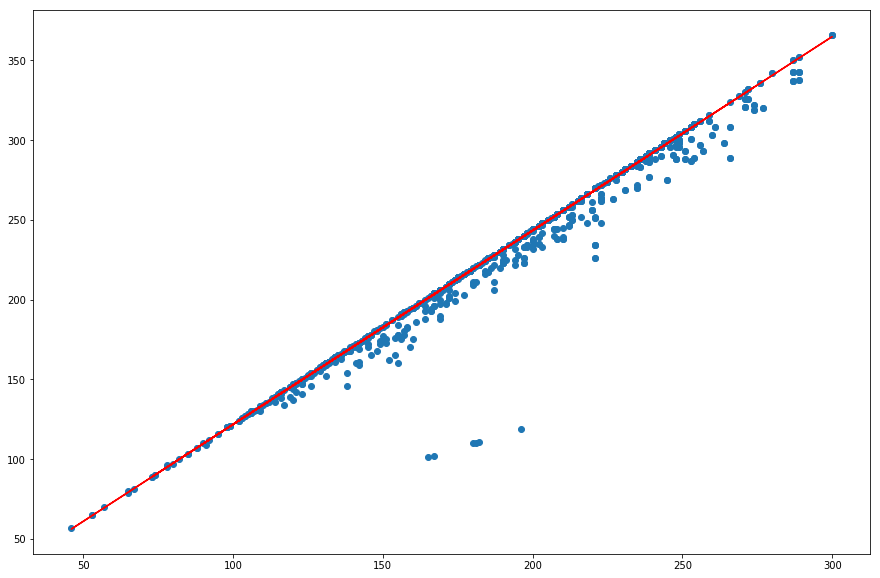

In [92]:
import scipy.stats as sp
import statsmodels.api as sm

alkrelate = chem_stations.dropna(subset=['HCO3','Alk'])
alkrelate
plt.scatter(alkrelate['Alk'],alkrelate['HCO3'])
x = alkrelate['Alk'] 
y = alkrelate['HCO3']

xa = sm.add_constant(x)

est = sm.RLM(y.astype(float), xa.astype(float)).fit()
r2 = sm.WLS(y.astype(float), xa.astype(float), weights=est.weights).fit().rsquared
slope = est.params[1]

#x_prime = np.linspace(np.min(x0), np.max(x0), 100)[:, np.newaxis]
#x_prime = sm.add_constant(x_prime)
#y_hat = est.predict(x_prime)

const = est.params[0]
#y2 = [i * slope + const for i in x0]



#slope, intercept, r_value, p_value, std_err = sp.linregress(x,y)
plt.plot(x,[i*slope+const for i in x],color='red')
print(r2)

for ind in chem_stations.index:
    if pd.isnull(chem_stations.loc[ind,'HCO3']) and pd.notnull(chem_stations.loc[ind,'Alk']):
        chem_stations.loc[ind,'HCO3'] = chem_stations.loc[ind,'Alk']*slope + const
        

In [93]:
def checkcomplete(df):
    df['complete'] = 0
    par_list = ['Ca', 'Na', 'Mg', 'SO4', 'Cl', 'K', 'HCO3', 'CO3', 'NaK']
    main_par = ['Ca', 'Na', 'Mg', 'SO4', 'Cl']

    if df[main_par].notnull().all() and df['CO3'] is None:
        df['CO3'] = 0
    if df[main_par].notnull().all() and (pd.isnull(df['NaK'])) and df[['Na','K']].isnull().all():
        df['NaK'] = 0
    else:
        df['NaK'] = df['Na'] + df['K']
    if df[main_par].isnull().any():
        pass
    elif df[main_par].notnull().all():
        df[par_list] = pd.to_numeric(df[par_list], errors='ignore', downcast='float')
        df['complete'] = 1
    return df

chem_stations = chem_stations.apply(checkcomplete,1)

In [94]:
par_list = ['Ca', 'Na', 'Mg', 'SO4', 'Cl', 'K', 'HCO3', 'CO3', 'NaK']
#chem_stations[chem_stations['complete']==1][par_list]

In [95]:
chem_stations['NewestCompl']= 0
df = chem_stations[chem_stations['complete']==1]

df['SampleDate'] = pd.to_datetime(df['SampleDate'])

ch_dates1 = df.sort_values(['StationId','SampleDate'],ascending=False)
ch_dates1 = ch_dates1.drop_duplicates(subset='StationId',keep='first')
last_samp1 = ch_dates1['SampleId']
df.loc[(df["SampleId"].isin(last_samp1)),'NewestCompl'] = 1
#chem_stations[['StationId','SampleId','SampleDate','IsNewest']]
df.drop_duplicates(inplace=True)
df1 = convertIons(df)

c:\program files\arcgis\pro\Resources\ArcToolbox\Scripts\FeatureclassConversion.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
c:\program files\arcgis\pro\Resources\ArcToolbox\Scripts\FeatureclassConversion.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/p

In [96]:
df2 = chem_stations[chem_stations['complete'] == 0]
df3 = pd.concat([df1,df2],axis=0)

In [97]:
ctdslist = ['Ca', 'Mg', 'NaK', 'SO4', 'Cl', 'HCO3', 'CO3', 'CO2', 'NO3', 'PO4']
df3['CalcTDS'] = df3[ctdslist].sum(axis=1)

In [99]:
field_order = [
    'StationId', 'StationName', 'StationType',
    'Easting', 'Northing', 'Elev',
    'HUC08', 'HUC10', 'HUC12', 'Lat_Y', 'Lon_X', 
    'data_source',
    'SampleDate', 'SampleId', 'IsNewest', 'complete','NewestCompl',
    'pH', 'Temp', 'TDS','CalcTDS', 'Cond', 
    'Ca', 'Mg', 'K', 'Na', 'NaK', 
    'SO4', 'Cl', 'HCO3','CO3', 
    'Alk', 
    'SO4_meq', 'Ca_meq', 'CO3_meq', 'Cl_meq', 'HCO3_meq',
    'Mg_meq', 'K_meq', 'NaK_meq', 'Na_meq', 
    'anions', 'cations', 'maj_anion',
    'maj_cation', 'total_ions', 'water_type', 'CBE', 'EC', 
    'NO3+NO2-N','NH3-N',
    'N', 'NH3', 'NO2', 'NO3', 'PO4', 'P',
    'Ag',
    'Al', 'As', 'B', 'Ba', 'Be', 'Br', 'C', 
    'CO2', 'CaCO3', 'Cd',
    'Co', 'Cr', 'Cu', 'F', 'Fe', 'Hg',
    'Ni', 'P', 'Pb', 'Sb', 'Se', 'Si', 'Sn', 'Mn', 'Mo',
    'Zn', 'Q', 'TSS', 'Turb', 'DO', 
    'OH', 'Hard']

df3 = df3[field_order]


In [113]:
def fixStType(df):
    if df['StationType'] in ['Canal Irrigation','Canal Transport']:
        df['StationType'] = 'Canal'
    elif df['StationType'] == 'Intake':
        df['StationType'] = 'Spring'
    return df
df3 = df3.apply(fixStType, axis=1)


In [114]:
df3.to_csv(fileplace+'Chem_pivot.csv',columns=field_order)
df3.to_pickle(fileplace+'Chem_pivot.pickle')

In [303]:
def fixna(df):
    if pd.isnull(df['ResultValue']):
        df['ResultValue'] = pd.to_numeric(df['MDL'],errors='coerce')
    return df

chemistry['cen'] = chemistry['DetectCond'].isin(['<'])

chemistry = chemistry.apply(fixna,1)

def dget(x):
    if st_dict[key].get(x) is not None:
        return st_dict[key].get(x)
    else:
        try:
            return st_dict[key].get(int(x))
        except:
            return None

for key,value in st_dict.items():
    chemistry[key] = chemistry['StationId'].apply(lambda x: dget(x),1)

In [304]:
chemistry.to_csv(fileplace+'Chemistry.csv',columns=field_order)
chemistry.to_pickle(fileplace+'Chemistry.pickle')

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\pandas\io\formats\format.py:1586: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  self.obj = self.obj.loc[:, cols]
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\pandas\core\indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


## Subset Round Valley

In [18]:
stations = pd.read_pickle(fileplace+ 'all_stations.pickle')

df3 = pd.read_pickle(fileplace+'Chem_pivot.pickle')

In [30]:
df3[['StationId','SampleId','complete']].groupby(df3['data_source']).nunique()

,StationId,SampleId,complete
data_source,,,
Loughlin,3,3,2
SDWIS,25,2058,2
UGS,7,33,1
WQP,96,8141,2


In [19]:
rvhucs = ['160202030403','160202030402','160202030404']

In [20]:
rv_piv_chm = df3[(df3['HUC12'].isin(rvhucs))]


In [21]:
allsampcount = rv_piv_chm[['StationId','SampleId','complete']].groupby(rv_piv_chm['data_source']).nunique()

In [22]:
allsampcount

,StationId,SampleId,complete
data_source,,,
Loughlin,3,3,2
SDWIS,3,95,2
UGS,7,33,1
WQP,41,3526,2


In [26]:
rv_gw_piv_chm = df3[(df3['HUC12'].isin(rvhucs))&(df3['StationType'].isin(['Well','Spring']))]

In [27]:
gwsampcount = rv_gw_piv_chm[['StationId','SampleId','complete']].groupby([rv_gw_piv_chm['data_source']]).nunique()
gwsampcount

,StationId,SampleId,complete
data_source,,,
Loughlin,3,3,2
SDWIS,3,95,2
UGS,6,30,1
WQP,18,326,2


# Plots

In [28]:
df3.StationType.unique()

array(['Well', 'Spring', 'Stream', 'Canal'], dtype=object)

In [24]:
piv_piper = df3.dropna(subset=['Ca','Na','SO4','Cl','Mg','HCO3'])
#piper = piv_piper[(piv_piper['Na'] > 0)&(piv_piper['SO4'] > 0)&(piv_piper['Cl'] > 0)]
pipe = reind_inc(piv_piper)



C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


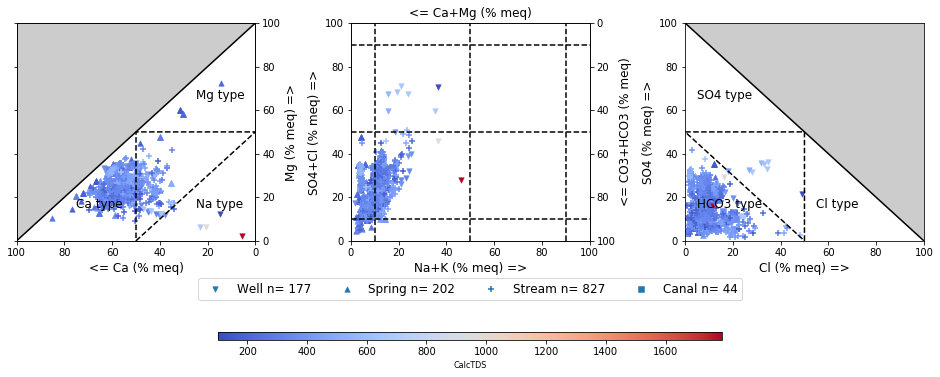

In [25]:
wa.piper(pipe,type_col='StationType',var_col='CalcTDS')
matplotlib.rc('pdf', fonttype=42)
plt.savefig(fileplace+'piper1.pdf')

In [ ]:
st_piper = pipe[(pipe['StationType'].isin(['Stream','Canal']))]
#st_piper = reind_inc(st_piper)
wa.piper(st_piper,type_col='StationType',var_col='TDS')
matplotlib.rc('pdf', fonttype=42)
plt.savefig(fileplace+'st_piper2.pdf')
st_piper.to_csv(fileplace+'st_piper2.csv')

In [ ]:
gw_piper = pipe[(pipe['StationType'].isin(['Spring','Well']))]
#gw_piper = reind_inc(gw_piper)
wa.piper(gw_piper,type_col='StationType',var_col='TDS')
matplotlib.rc('pdf', fonttype=42)
plt.savefig(fileplace+'round_valley_gw_piper2.pdf')
gw_piper.to_csv(fileplace+'gw_piper2.csv')

In [ ]:
rvgw_piper = pipe[(pipe['StationType'].isin(['Spring','Well']))&(pipe['HUC12'].isin(rvhucs))]
#rvgw_piper = reind_inc(rvgw_piper)
wa.piper(rvgw_piper,type_col='StationType',var_col='TDS')
matplotlib.rc('pdf', fonttype=42)
plt.savefig(fileplace+'round_valley_gw_piper2.pdf')
rvgw_piper.to_csv(fileplace+'round_valley_gw_piper2.csv')

In [ ]:

strcnt = {}
i=0

#f#ig, [ax1,ax2,ax3,ax4] = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)

pipe.boxplot(column=['TDS','HCO3'], by='StationType',return_type='axes')
pipe.boxplot(column=['Ca','Na'], by='StationType',return_type='axes')
piv_counts_prep = pipe.dropna(subset=['TDS'])[['StationType','StationId','SampleId']]
piv_counts = piv_counts_prep.groupby('StationType').nunique()[['StationId','SampleId']]

#axes[1,:].set_ylim(1,100)
#axes[0,:].set_ylim(1,1000)

for ind in piv_counts.index:
    for col in piv_counts.columns:
         strcnt[ind+"_"+col] = piv_counts.loc[ind,col]
    i += 1
    print(ind)
    sampcount = strcnt[ind+'_SampleId']
    statcount = strcnt[ind+'_StationId']
    #plt.text(i, 700, 
    #         "Sample Count = {:}\nStation Count = {:}".format(sampcount,statcount),
    #        horizontalalignment='center')
#plt.ylim(1,1000)
plt.ylabel('Concentration (mg/L)')


#plt.yscale('log')

plt.xlabel('Station Type')

plt.savefig(fileplace+'TDS_boxplot.pdf')

In [109]:
import seaborn as sns

In [116]:
#sns.violinplot(x='StationType',y='NO3+NO2-N',data=pipe,width=1)
sns.swarmplot(x='StationType', y='NO3+NO2-N', hue="Cond", data=pipe)
plt.grid()


NameError: name 'pipe' is not defined

In [129]:
rv.columns

Index(['StationId', 'StationName', 'StationType', 'Easting', 'Northing',
       'Elev', 'HUC08', 'HUC10', 'HUC12', 'Lat_Y', 'Lon_X', 'data_source',
       'SampleDate', 'SampleId', 'IsNewest', 'complete', 'NewestCompl', 'pH',
       'Temp', 'TDS', 'CalcTDS', 'Cond', 'Ca', 'Mg', 'K', 'Na', 'NaK', 'SO4',
       'Cl', 'HCO3', 'CO3', 'Alk', 'SO4_meq', 'Ca_meq', 'CO3_meq', 'Cl_meq',
       'HCO3_meq', 'Mg_meq', 'K_meq', 'NaK_meq', 'Na_meq', 'anions', 'cations',
       'maj_anion', 'maj_cation', 'total_ions', 'water_type', 'CBE', 'EC',
       'NO3+NO2-N', 'NH3-N', 'N', 'NH3', 'NO2', 'NO3', 'PO4', 'P', 'Ag', 'Al',
       'As', 'B', 'Ba', 'Be', 'Br', 'C', 'CO2', 'CaCO3', 'Cd', 'Co', 'Cr',
       'Cu', 'F', 'Fe', 'Hg', 'Ni', 'P', 'Pb', 'Sb', 'Se', 'Si', 'Sn', 'Mn',
       'Mo', 'Zn', 'Q', 'TSS', 'Turb', 'DO', 'OH', 'Hard'],
      dtype='object')

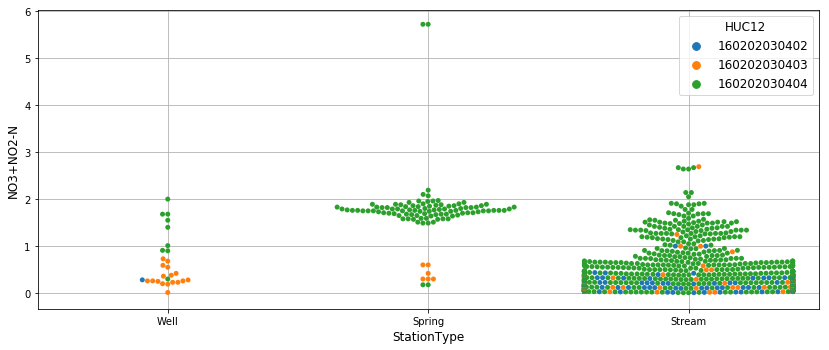

In [133]:
rv = df3[(df3['HUC12'].isin(rvhucs))&(pd.notnull(df3['NO3+NO2-N']))]

sns.swarmplot(x=rv['StationType'], y=rv['NO3+NO2-N'], hue=rv['HUC12'])#, data=rv)
plt.grid()


## Nondetects

In [288]:
def getros(chem, roundv=True, stype=''):
    if type(chem) == list:
        pass
    else:
        chem = [chem]
    
    if roundv:
        df = chemistry[(chemistry['ParAbb'].isin(chem))&(chemistry['HUC12']).isin(rvhucs)]
    else:
        df = chemistry[(chemistry['ParAbb'].isin(chem))]
        
    if stype == 'gw':
        df = df[df['StationType'].isin(['Spring','Well'])]
    elif stype == 'sw':
        df = df[df['StationType'].isin(['Stream','Canal'])]
        
    df = df[df['StationId'].isin(rvstations)]

    df=df.sort_values(['cen','ResultValue'],ascending=[False,True])
    try:
        df['ros'] = wqio.ros.ROS('ResultValue','cen',df=df,as_array=True,transform_in=np.log)
        dd = wqio.ros.ROS('ResultValue','cen',df=df,as_array=False,transform_in=np.log)
    
    except:

        dd = wqio.ros.ROS('ResultValue','cen',df=df,as_array=False,transform_in=np.log)
    
    return df,dd

In [285]:
rvchem = chemistry[chemistry['HUC12'].isin(rvhucs)]

rvchem.groupby('ParAbb').nunique()[['SampleId','StationId','StationType','HUC12']].sort_values('SampleId',ascending=False)

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\pandas\core\groupby.py:3406: FutureWarning: In the future, NAT != NAT will be True rather than False.
  inc = np.r_[1, val[1:] != val[:-1]]


,SampleId,StationId,StationType,HUC12
ParAbb,,,,
pH,1530,42,3,3
Cond,1446,43,3,3
Q,1377,28,3,3
Temp,1275,40,3,3
TSS,1267,25,3,3
TDS,1243,45,3,3
DO,1200,18,3,3
NO3+NO2-N,1091,38,3,3
HCO3,1037,29,3,3


In [367]:
rvchem[(rvchem['ParAbb'].isin(['NO3','NO3+NO2-N']))&(rvchem['ResultValue']>3.0)][['ResultValue',
                                                                                  'StationName',
                                                                                  'StationId']].sort_values('ResultValue',ascending=False).to_clipboard()

In [341]:
rvchem[rvchem['StationType'].isin(['Well','Spring'])]['ParAbb'].unique()


array(['Cd', 'Ca', 'Cr', 'Cu', 'Fe', 'Pb', 'Mg', 'Mn', 'Ni', 'K', 'Ag',
       'Na', 'Zn', 'Sb', 'As', 'Se', 'Tl', None, 'HCO3', 'CO3', 'OH',
       'Alk', 'Cl', 'Cond', 'NO3', 'pH', 'PO3', 'P', 'SO4', 'TDS', 'Hard',
       'Temp', 'ORP', 'TSS', 'Turb', 'Si', 'CO2', 'NH3-N', 'NO3+NO2-N',
       'PO4', 'B', 'Sn', 'Be', 'Ba', 'CN', 'F', 'Hg', 'NO2', 'Q', 'DO',
       'N', 'Al', 'NH3', 'NaK'], dtype=object)

In [364]:

chemlist = rvchem[rvchem['StationType'].isin(['Well','Spring'])]['ParAbb'].unique()

chemlist = ['Cd', 'Ca', 'Cr', 'Cu', 'Fe', 'Pb', 'Mg', 'Mn', 'Ni', 'K', 'Ag',
       'Na', 'Zn', 'Sb', 'As', 'Se', 'Tl', 'HCO3', 'CO3', 'OH', 'Alk', 'Cl', 
            'Cond', 'NO3', 'pH', ['PO3', 'P'], 'SO4', 'TDS', 'Hard',
       'Temp', 'ORP', 'TSS', 'Turb', 'Si', 'CO2', 'NH3-N', ['NO3+NO2-N','NO3'],
       'PO4', 'B', 'Sn', 'Be', 'Ba', 'CN', 'F', 'Hg', 'NO2', 'Q', 'DO',
       'N', 'Al', 'NH3', 'NaK']
sd= {}
for chem in chemlist:
    if type(chem) == list:
        ch = chem
        chem = ','.join(chem)
    else:
        ch = chem
        
    sd[chem] = {}
    df,dd = getros(ch,stype='gw')
    sd[chem]['sample count'] = df.groupby(['StationId','ParAbb']).nunique()['SampleId'].sum()
    sdata = df.groupby(['StationId','ParAbb']).mean()

    
    
    try:

        sdatar = sdata['ros']
        sd[chem]['nada'] = 'yes'

    except KeyError:
        print('No {:}'.format(chem))
        sdatar = sdata['ResultValue']
        sd[chem]['nada'] = 'no'

    sd[chem]['max'] = sdatar.max()
    sd[chem]['min'] = sdatar.min()
    sd[chem]['geomean'] = scipy.stats.mstats.gmean(sdatar)
    sd[chem]['mean'] = sdatar.mean()
    sd[chem]['median'] = sdatar.median()
    sd[chem]['std'] = sdatar.std()
    sd[chem]['station count'] = sdatar.count()

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\pandas\core\groupby.py:3406: FutureWarning: In the future, NAT != NAT will be True rather than False.
  inc = np.r_[1, val[1:] != val[:-1]]
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\wqio\ros.py:41: UserWarning: Dropping censored results greater than the max uncensored result.
  warnings.warn(msg)


No Cr
No Cu
No Fe
No Pb
No Mn
No Zn
No As
No Se


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\wqio\ros.py:383: RuntimeWarning: divide by zero encountered in log
  transform_in(df[result][uncensored_mask])
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\numpy\lib\function_base.py:3087: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\Program

No OH
No B
No Ba


In [366]:
pd.DataFrame(sd).T.to_clipboard()

0.0697958370666
0.110119105293 0.06428044918032785 0.141938235946


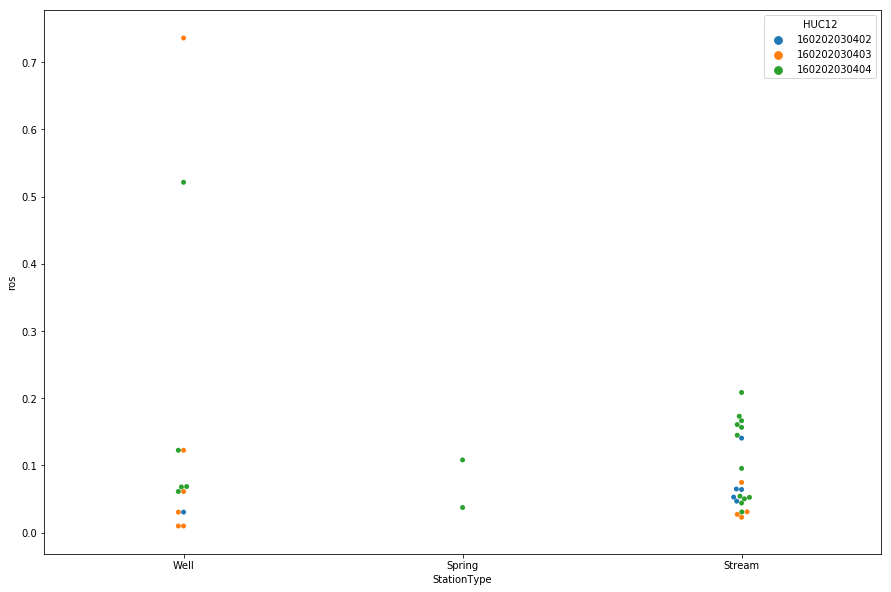

In [321]:
df,dd = getros(['PO3','P'],stype='')

sdata = df.groupby(['StationId','ParAbb']).mean()
sdatar = sdata['ros']
print(scipy.stats.mstats.gmean(sdatar))
print(sdatar.mean(),sdatar.median(),sdatar.std())
sdata.reset_index(inplace=True)
for key,value in st_dict.items():
    sdata[key] = sdata['StationId'].apply(lambda x: dget(x),1)


sns.swarmplot(x='StationType', y='ros', data=sdata, hue='HUC12')


0.470396360444
1.09411482873 0.543009090909091 1.63096197109


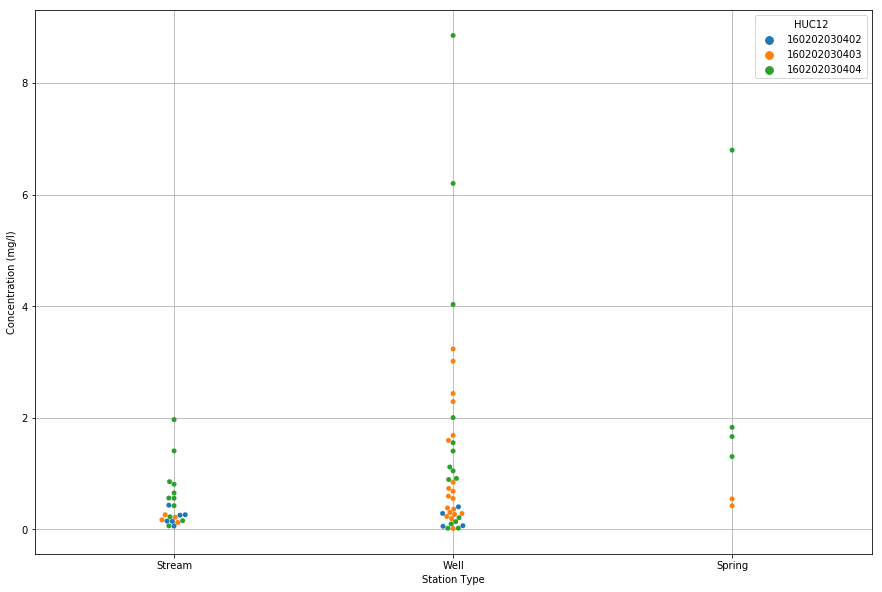

In [325]:
df,dd = getros(['NO3','NO3+NO2-N'],stype='')

sdata = df.groupby(['StationId','ParAbb']).mean()
sdatar = sdata['ros']
print(scipy.stats.mstats.gmean(sdatar))
print(sdatar.mean(),sdatar.median(),sdatar.std())
sdata.reset_index(inplace=True)
for key,value in st_dict.items():
    sdata[key] = sdata['StationId'].apply(lambda x: dget(x),1)


sns.swarmplot(x='StationType', y='ros', data=sdata, hue='HUC12')
plt.ylabel('Concentration (mg/l)')
plt.xlabel('Station Type')
plt.grid()

0.743264856842
1.41920141101 0.7050000000000001 1.87256843761


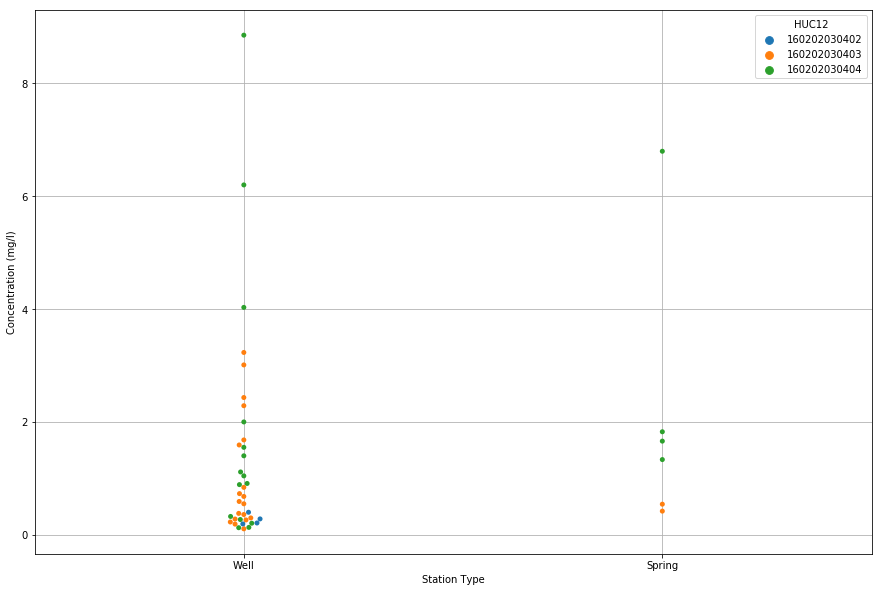

In [336]:
df,dd = getros(['NO3','NO3+NO2-N'],stype='gw')

sdata = df.groupby(['StationId','ParAbb']).mean()
sdatar = sdata['ros']
print(scipy.stats.mstats.gmean(sdatar))
print(sdatar.mean(),sdatar.median(),sdatar.std())
sdata.reset_index(inplace=True)
for key,value in st_dict.items():
    sdata[key] = sdata['StationId'].apply(lambda x: dget(x),1)


sns.swarmplot(x='StationType', y='ros', data=sdata, hue='HUC12')
plt.ylabel('Concentration (mg/l)')
plt.xlabel('Station Type')
plt.grid()

In [301]:
sdata = df.groupby(['StationId','ParAbb']).mean()['ros']
print(geo_mean_overflow(sdata),geo_mean(sdata), scipy.stats.mstats.gmean(sdata))

0.0673149504139 0.0673149504139 0.0673149504139


In [293]:
scipy.stats.mstats.gmean(df['ros'])


0.06429880116177196

In [ ]:
rv = df3[(df3['HUC12'].isin(rvhucs))&(pd.notnull(df3['NO3+NO2-N']))]

sns.swarmplot(x=rv['StationType'], y=rv['NO3+NO2-N'], hue=rv['HUC12'])#, data=rv)
plt.grid()

In [195]:
df.final.median()

0.319

In [192]:
NO3['ros']

68      0.006238
92      0.007022
116     0.008047
140     0.008459
164     0.009124
225     0.009407
247     0.010549
28      0.010646
134     0.010719
137     0.011126
237     0.011554
282     0.012065
374     0.012467
490     0.012650
513     0.013180
565     0.013258
602     0.013310
612     0.014099
620     0.014239
881     0.014344
938     0.014844
1059    0.014933
1063    0.015352
1069    0.015554
1070    0.016233
1074    0.016299
1075    0.016499
1078    0.016605
1085    0.016887
1086    0.017064
          ...   
7686    2.870000
7699    2.890000
7700    2.900000
7713    2.930000
7714    2.970000
7742    2.980000
7743    3.010000
7759    3.200000
7760    3.350000
7774    3.410000
7775    3.440000
7788    3.450000
7789    3.599000
7802    3.643000
7803    3.670000
7817    3.780000
7818    3.780000
7866    3.820000
7867    3.950000
7901    4.200000
7902    4.260000
7925    4.408000
7926    4.450000
7939    5.000000
7940    5.380000
7953    5.630000
7968    5.720000
7969    5.7200

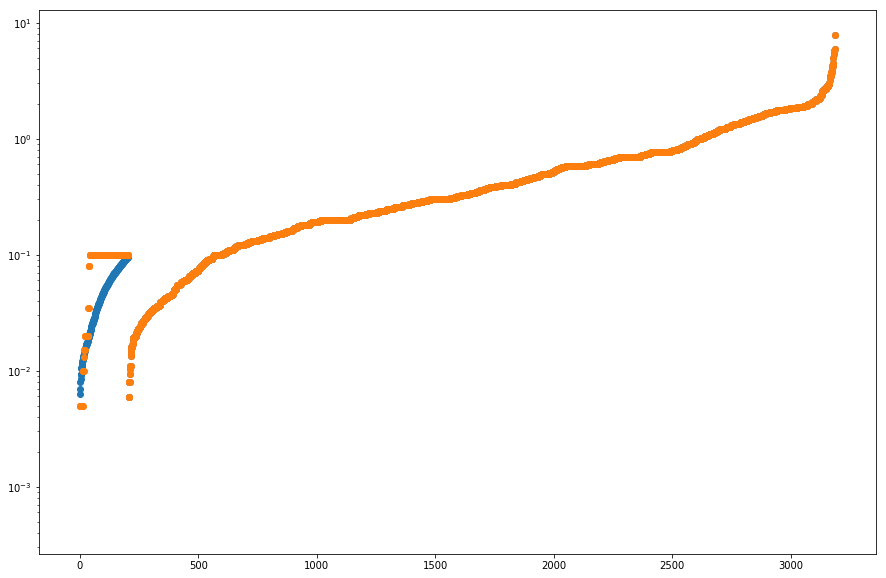

In [190]:
plt.scatter(df.index,NO3['ros'])
plt.scatter(df.index,NO3.ResultValue)
plt.yscale('log')

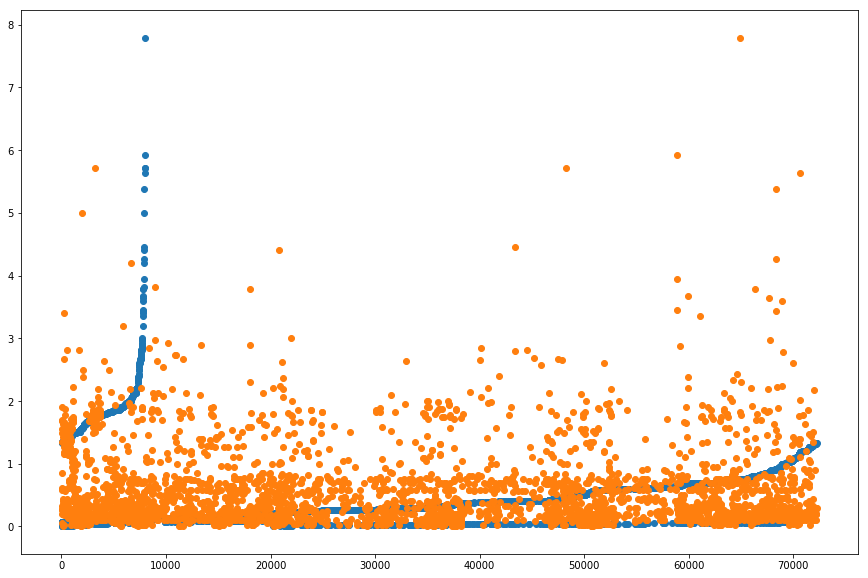

In [176]:
plt.scatter(NO3.index, NO3['ros'])
plt.scatter(NO3.index, NO3['ResultValue'])

In [ ]:


sns.swarmplot(x='StationType', y='N', hue="HUC12", data=rv)
plt.grid()


In [ ]:
pipe.boxplot(column=['NO3+NO2-N'], by='StationType',return_type='axes')

In [ ]:
d3[[]]

In [ ]:


import numpy as np
import pandas

import wqio

main_cols = [
    'epa_rain_zone', 'season', 'primary_landuse',
    'parameter', 'fraction', 'units', 'res', 'qual'
]

df = pandas.read_csv("nsqdata_example_subset.csv", usecols=main_cols)
df['cen'] = df['qual'].isin(['<'])
df.head()



In [ ]:
piv_stations = piv_chm.groupby('StationId').median()
piv_stations.to_csv(fileplace+'all_pivot_stations.csv')

In [ ]:
df2PntFt(piv_chm,'Lon_X', u'Lat_Y',
         'C:/Users/PAULINKENBRANDT/Documents/ArcGIS/Projects/Round Valley/',
         'comb_piv',
         'Round Valley.gdb','4326')
